# Touchscreen Dataset Analysis

### Package Import and Path Configuration
This section imports all required packages and defines the file paths needed for the analysis.

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import defaultdict
from sklearn.model_selection import train_test_split
from helpers.readFiles import load_tsv, load_csv
from helpers.processDataframes import (na_elimination, 
                                       impute_by_disease, 
                                       get_highly_correlated_columns_from_matrix, 
                                       eliminate_fields_by_fieldID, 
                                       remove_outliers_and_align_datasets, 
                                       rename_columns_with_field_names, 
                                       rename_onehot_columns,
                                       merge_dataframes_on_eid)
from helpers.vizualization import (create_boxplots, 
                                   correlation_matrix_spearman, 
                                   correlation_matrix_crammer, 
                                   create_histograms, 
                                   visualize_correlation_matrix)
from helpers.oneHotEncoding import (onehot_encode_simple_nominal, 
                                    onehot_encode_multiple_nominal)
from helpers.scaleDataFrame import scale_numeric_columns

# Set the path to the directory containing the raw data files
inputpath = "../main/data/UK_BIOBANK_DATA" 
path_graphs = "../main/doutputs/graphs" 
path_results = "../main/doutputs/results" 
path_outputs = "/outputs"

The touchscreen dataset is loaded. This dataset is provided with a tab separator format. For that reason, the following code was used.

In [2]:
#Charge dataframes
#Touchscreen
touchscreen_df = load_tsv("touchscreen_data.tsv", inputpath)

# Display the first few rows of the touchscreen data
touchscreen_df.head()

Looking for file at: ../main/data/UK_BIOBANK_DATA/touchscreen_data.tsv
File loaded: 502180 rows × 1541 columns


,eid,f_670_0_0,f_670_1_0,f_670_2_0,f_670_3_0,f_680_0_0,f_680_1_0,f_680_2_0,f_680_3_0,f_699_0_0,...,f_22037_2_0,f_22037_3_0,f_22038_0_0,f_22038_1_0,f_22038_2_0,f_22038_3_0,f_22039_0_0,f_22039_1_0,f_22039_2_0,f_22039_3_0
0,1000012,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1000021,1.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,24.0,...,NaN,NaN,4320.0,NaN,NaN,NaN,320.0,NaN,NaN,NaN
2,1000035,1.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,10.0,...,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN
3,1000044,1.0,1.0,NaN,NaN,2.0,2.0,NaN,NaN,27.0,...,NaN,NaN,0.0,240.0,NaN,NaN,0.0,960.0,NaN,NaN
4,1000053,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,32.0,...,NaN,NaN,240.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN


The chars dataset is loaded, which contains information relevant to the original dataset. This is done to gain more information, better understand the dataset, and make future associations.

In [3]:
touchscreen_chars_df = load_tsv("touchscreen_chars.tsv", inputpath, skiprows=5)

touchscreen_chars_df.head()

Looking for file at: ../main/data/UK_BIOBANK_DATA/touchscreen_chars.tsv
File loaded: 379 rows × 17 columns


,Field,FieldID,ValueType,Coding,Category,Participants,Items,Stability,Units,ItemType,Strata,Sexed,Instances,Array,Notes,Link,Path
0,Type of accommodation lived in,670,Categorical single,100286.0,100066,501527,597706,Complete,NaN,Data,Primary,Unisex,4,1,"ACE touchscreen question """"""""What type of acco...",http://biobank.ndph.ox.ac.uk/ukb/field.cgi?id=670,Assessment centre > Touchscreen > Sociodemogra...
1,Own or rent accommodation lived in,680,Categorical single,100287.0,100066,500149,596187,Complete,NaN,Data,Primary,Unisex,4,1,"ACE touchscreen question """"""""Do you own or ren...",http://biobank.ndph.ox.ac.uk/ukb/field.cgi?id=680,Assessment centre > Touchscreen > Sociodemogra...
2,Length of time at current address,699,Integer,100290.0,100066,501523,597702,Complete,years,Data,Primary,Unisex,4,1,"ACE touchscreen question """"""""How many years ha...",http://biobank.ndph.ox.ac.uk/ukb/field.cgi?id=699,Assessment centre > Touchscreen > Sociodemogra...
3,Number in household,709,Integer,100291.0,100066,500147,596185,Complete,people,Data,Primary,Unisex,4,1,"ACE touchscreen question """"""""Including yoursel...",http://biobank.ndph.ox.ac.uk/ukb/field.cgi?id=709,Assessment centre > Touchscreen > Sociodemogra...
4,Number of vehicles in household,728,Categorical single,100293.0,100066,500147,596185,Complete,NaN,Data,Primary,Unisex,4,1,"ACE touchscreen question """"""""How many cars or ...",http://biobank.ndph.ox.ac.uk/ukb/field.cgi?id=728,Assessment centre > Touchscreen > Sociodemogra...


Load the file containing the codes of the categorical questions

In [4]:
#Charge dataframes
#Touchscreen
touchscreen_cbkeys_df = load_tsv("touchscreen_cbkeys.tsv",inputpath)

touchscreen_cbkeys_df.head()

Looking for file at: ../main/data/UK_BIOBANK_DATA/touchscreen_cbkeys.tsv
File loaded: 889 rows × 6 columns


,coding_name,code,meaning,concept,display_order,parent_code
0,7,1,Yes,NaN,1,NaN
1,7,0,No,NaN,2,NaN
2,100286,1,A house or bungalow,NaN,1,NaN
3,100286,2,"A flat, maisonette or apartment",NaN,2,NaN
4,100286,3,Mobile or temporary structure (i.e. caravan),NaN,3,NaN


Load IBD categories

In [5]:
ibd0_df= load_tsv("ibd0.tsv", inputpath)

ibd0_df.head()

Looking for file at: ../main/data/UK_BIOBANK_DATA/ibd0.tsv


File loaded: 22625 rows × 2009 columns


,eid,CD,UC,IBD,Disease,TM1,season,Age1,AssessmentCentre,CD2T1,...,ZBTB16,ZBTB17,ZCCHC8,ZFYVE19,ZHX2,ZNF174,ZNF75D,ZNF830,ZNRD2,ZNRF4
0,2227199,NaN,NaN,1993-04-07,IBD,2007-12-07,Winter,57,11003,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5822919,NaN,NaN,2021-10-26,IBD,2008-05-19,Spring,51,11008,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3122877,NaN,NaN,2022-05-13,IBD,2009-05-27,Spring,63,11011,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5296207,NaN,NaN,2002-05-30,IBD,2009-03-23,Spring,42,11007,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1847013,NaN,NaN,1999-08-24,IBD,2008-08-01,Summer,65,11007,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Merge touchscreen data frame with IBD categories.

In [6]:
touchscreen_df = touchscreen_df.merge(ibd0_df[['eid', 'Disease']], on='eid', how='left')

touchscreen_df = touchscreen_df.dropna(subset=['Disease'])

touchscreen_df['Disease'].value_counts(dropna=False)

Disease
Control    18999
IBD         3109
UC           327
CD           190
Name: count, dtype: int64

Merge touchscreen data frame with IBD categories.

## Preprocessing

### Missing Values

The tests were conducted in three (3) stages. Across these stages, only instances 0 and 1 were retained, because this stage contains the least amount of missing data.

In [7]:
# Select columns that match the pattern 'f_\d+_0_\d+' and include 'eid'
# _instances_array 
# instances cohort 
# array number of options 

selected_columns = ['eid'] + [
    col for col in touchscreen_df.columns
    if re.match(r'^f_\d+_0_\d+$', col)
]

# Create a new DataFrame with the selected columns
touchscreen_dr_df = touchscreen_df[selected_columns]

touchscreen_dr_df.head()

,eid,f_670_0_0,f_680_0_0,f_699_0_0,f_709_0_0,f_728_0_0,f_738_0_0,f_757_0_0,f_767_0_0,f_777_0_0,...,f_20162_0_0,f_21000_0_0,f_22032_0_0,f_22033_0_0,f_22034_0_0,f_22035_0_0,f_22036_0_0,f_22037_0_0,f_22038_0_0,f_22039_0_0
28,1000298,1.0,1.0,34.0,1.0,1.0,2.0,NaN,NaN,NaN,...,NaN,5.0,2.0,16.0,70.0,1.0,1.0,396.0,600.0,800.0
75,1000767,1.0,1.0,17.0,2.0,3.0,3.0,NaN,NaN,NaN,...,NaN,1001.0,1.0,10.0,70.0,1.0,1.0,297.0,600.0,160.0
94,1000952,1.0,2.0,5.0,5.0,3.0,-1.0,12.0,37.0,5.0,...,NaN,3001.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
129,1001301,2.0,3.0,4.0,3.0,2.0,-3.0,4.0,50.0,6.0,...,0.580645,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
134,1001358,1.0,2.0,15.0,1.0,2.0,2.0,18.0,37.0,5.0,...,NaN,1001.0,1.0,5.0,130.0,0.0,1.0,396.0,480.0,80.0


We verify whether duplicate records exist according to the 'eid' column.

In [8]:
# Check for duplicates in 'eid'
duplicates = touchscreen_dr_df[touchscreen_df["eid"].duplicated(keep=False)]

# Display duplicate rows (if any)
if not duplicates.empty:
    print(f"Found {len(duplicates)} duplicate rows in 'eid':")
    display(duplicates)
else:
    print("No duplicates found in 'eid'.")

touchscreen_dr_df.shape

No duplicates found in 'eid'.


(22625, 480)

Elimination of non-relevant questions integer

| Field ID  | Question |
|-----------|-----------|
| 699       | Length of time at current address   |
| 709       | Number in household |
| 1070      | Time spent watching television (TV) * |
| 1845      | Mother's age |
| 2946      | Father's age |
| 3659      | Year immigrated to UK (United Kingdom) |
| 3672      | Number of adopted brothers |
| 3682      | Number of adopted sisters |
| 3526      | Mother's age at death |
| 1807      | Father's age at death |

Elimination of non-relevant questions categorical single

| Field ID  | Question |
|-----------|-----------|
| 670       | Type of accommodation lived in   |
| 728       | Number of vehicles in household |
| 780       | Own or rent accommodation lived in |
| 1011      | Frequency of light DIY in last 4 weeks |
| 1021      | Duration of light DIY |
| 1031      | Frequency of friend/family visits |
| 1707      | Handedness (chirality/laterality) |
| 1767      | Adopted as a child |
| 1797      | Father still alive |
| 1835      | Mother still alive |
| 3912      | Adopted father still alive |
| 3942      | Adopted mother still alive |
| 4825      | Noisy workplace |
| 4836      | Loud music exposure frequency |
| 10105     | Internet user (pilot) |
| 10114     | Willing to be contacted by email (pilot) |
| 10740     | Frequency of friend/family visits (pilot) |
| 10749     | Time using mobile phone in last 3 months (pilot) * |
| 10818     | Reason for reducing amount of alcohol drunk (pilot) |
| 10877     | Average total household income before tax (pilot) * |
| 10886     | Difference in mobile phone use compared to one year previously (pilot) * |
| 20119     | Current employment status - corrected |


Elimination of non-relevant questions categorical multiple

| Field ID  | Question |
|-----------|-----------|
| 6138      | Qualifications  |
| 6139      | Gas or solid-fuel cooking/heating  |
| 6140      | Heating type(s) in home |
| 6143      | Transport type for commuting to job workplace |
| 6145      | Illness, injury, bereavement, stress in last 2 years |
| 6141      | How are people in household related to participant |
| 6142      | Current employment status |
| 6160      | Leisure/social activities |
| 10016     | Regular use of hands-free device/speakerphone with mobile phone (pilot) |
| 10015     | Why stopped smoking (pilot) |
| 20112     | Illnesses of adopted father |
| 20113     | Illnesses of adopted mother |
| 20114     | Illnesses of adopted siblings |

In [9]:
# List of irrelevant Field IDs to drop
irrelevant_ids = [
    # Integer
    "699", "709", "796" ,"1070", "1845", "2946", "3659", "3672", "3682", "3526", "1807"

    # Categorical single
    "670", "780", "1011", "1021", "1031", "1707", "1767", "1797", "1835",
    "2634", "3912", "3942", "4825", "4836", "10105", "10114", 
    "10740", "10818", "20119",

    # Categorical multiple
    "6138", "6139", "6140", "6145","6143", "6141","6142", "6160",
    "10016", "10015", "20112", "20113", "20114"
]

# Create a regex pattern to match columns with the specified IDs
pattern = re.compile(rf"^f_({'|'.join(irrelevant_ids)})_\d+_\d+$")

# Find columns that match the pattern
columns_to_drop = [col for col in touchscreen_dr_df.columns if pattern.match(col)]

# Drop the identified columns from the DataFrame
touchscreen_dr_df = touchscreen_dr_df.drop(columns=columns_to_drop)

# Validate the drop by checking the remaining columns
touchscreen_dr_df.head()

,eid,f_670_0_0,f_680_0_0,f_728_0_0,f_738_0_0,f_757_0_0,f_767_0_0,f_777_0_0,f_806_0_0,f_816_0_0,...,f_20162_0_0,f_21000_0_0,f_22032_0_0,f_22033_0_0,f_22034_0_0,f_22035_0_0,f_22036_0_0,f_22037_0_0,f_22038_0_0,f_22039_0_0
28,1000298,1.0,1.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,5.0,2.0,16.0,70.0,1.0,1.0,396.0,600.0,800.0
75,1000767,1.0,1.0,3.0,3.0,NaN,NaN,NaN,NaN,NaN,...,NaN,1001.0,1.0,10.0,70.0,1.0,1.0,297.0,600.0,160.0
94,1000952,1.0,2.0,3.0,-1.0,12.0,37.0,5.0,2.0,2.0,...,NaN,3001.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
129,1001301,2.0,3.0,2.0,-3.0,4.0,50.0,6.0,3.0,2.0,...,0.580645,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
134,1001358,1.0,2.0,2.0,2.0,18.0,37.0,5.0,1.0,1.0,...,NaN,1001.0,1.0,5.0,130.0,0.0,1.0,396.0,480.0,80.0


| Code    | Changed to | Mening     |
|---------|------------|------------|
| -27     | NA         | None of the above (group 2) |
| -23     | NA         | Prefer not to answer (group 2) |
| -21     | NA         | Do not know (group 2) |
| -17     | NA         | None of the above (group 1) |
| -13     | NA         | Prefer not to answer (group 1) |
| -7      | NA         | None of the above |
| -5      | NA         | Not sure |
| -4      | NA         | Do not remember |
| -3      | NA         | Prefer not to answer |
| -1      | NA         | Do not know |

Special cases
| Code    | Changed to | Codin_name | FieldID    |Mening     |
|---------|------------|------------|------------|------------|
| -11     | NA         | 100595     | 2804       | Still taking the pill |
| -11     | NA         | 100598     | 3546       | Still taking HRT |
| -11     | NA         | 1010       | 20107      | Do not know (group 1) |
| -10     | 0.5        | 100290  	| 699, 757   | Less than a year |
| -10     | 0.5        | 100298  	| 777        | Less than once a week |
| -10     | 0.5        | 100300  	| 796        | Less than one mile |
| -10     | 0.5        | 100329	    | 1050, 1060, 1070, 1080, 1090 | Less than an hour a day |
| -10     | 0.5        | 100373	    | 1289, 1299, 1309, 1319, 1438, 1458, 1488, 1528, | Less than one |
| -10     | 0.5        | 100537	    | 2277       | Less than once a year |
| -10     | 0.5        | 100567	    | 2355, 2684 | Less than 1 year ago |
| -10     | 0.5        | 100569	    | 2704, 3809 | Less than a year ago |
| -10     | 0.5        | 100353	    | 6183, 2887 | Less than one a day |
| -10     | 0.5        | 100355	    | 3456       | Less than one a day |
| -6      | 3          | 100416	    | 1618       | It varies |
| -6      | NA         | 100582	    | 3710       | Irregular cycle |
| -2      | -2         | 100306	    | 845        | Never went to school |
| -2      | -2         | 100307	    | 864        | Unable to walk |
| -2      | 4          | 100398	    | 1518       | Do not drink hot drinks |
| -2      | -2         | 100504	    | 2139       | Never had sex |
| -2      | -2         | 100585	    | 2744       | Only had twins |
| -2      | 3          | 100617	    | 4041       | Not applicable |

Spectial questions

| Field ID  | Question |
|-----------|-----------|
| 2804      | Age when last used oral contraceptive pill  |
| 3546      | Age last used hormone-replacement therapy (HRT) |
| 20107     | Illnesses of father |
| 1618      | Alcohol usually taken with meals (yes, no, it varies ) |
| 3710      | Lenght of menstrual cycle |
| 845       | Age completed full time education |
| 864       | Number of days/week walked 10+ minutes |
| 1518      | Hot drink temperature |
| 2139      | Age first had sexual intercurse |
| 2744      | Birth weight of first child |
| 4041      | Gestional diabetes only |

In [10]:
# Casos especiales por FieldID
field_replacements = {
    '3710': { -2: 3 },
    '4014': { -2: 3 },  
    '1518': { -2: 4 }
}

# Valores generales
general_replace = { -10: 0.5 }
na_values = [-27, -23, -21, -17, -13, -7, -5, -4, -3, -1, -11]

for col in touchscreen_dr_df.columns:
    if col != 'eid':
        touchscreen_dr_df[col] = touchscreen_dr_df[col].replace(general_replace)
        touchscreen_dr_df[col] = touchscreen_dr_df[col].replace(na_values, np.nan)

        match = re.match(r'f_(\d+)_\d+_\d+', col)
        if match:
            field_id = match.group(1)
            if field_id in field_replacements:
                touchscreen_dr_df[col] = touchscreen_dr_df[col].replace(field_replacements[field_id])

touchscreen_dr_df.head()

,eid,f_670_0_0,f_680_0_0,f_728_0_0,f_738_0_0,f_757_0_0,f_767_0_0,f_777_0_0,f_806_0_0,f_816_0_0,...,f_20162_0_0,f_21000_0_0,f_22032_0_0,f_22033_0_0,f_22034_0_0,f_22035_0_0,f_22036_0_0,f_22037_0_0,f_22038_0_0,f_22039_0_0
28,1000298,1.0,1.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,5.0,2.0,16.0,70.0,1.0,1.0,396.0,600.0,800.0
75,1000767,1.0,1.0,3.0,3.0,NaN,NaN,NaN,NaN,NaN,...,NaN,1001.0,1.0,10.0,70.0,1.0,1.0,297.0,600.0,160.0
94,1000952,1.0,2.0,3.0,NaN,12.0,37.0,5.0,2.0,2.0,...,NaN,3001.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
129,1001301,2.0,3.0,2.0,NaN,4.0,50.0,6.0,3.0,2.0,...,0.580645,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
134,1001358,1.0,2.0,2.0,2.0,18.0,37.0,5.0,1.0,1.0,...,NaN,1001.0,1.0,5.0,130.0,0.0,1.0,396.0,480.0,80.0


### Division of numerical and categorical data

In [11]:
touchscreen_chars_df['FieldID'] = touchscreen_chars_df['FieldID'].astype(int)

valuetype_map = touchscreen_chars_df.set_index('FieldID')['ValueType'].to_dict()

column_fieldid_map = {
    col: int(re.search(r'f_(\d+)_', col).group(1))
    for col in touchscreen_dr_df.columns
    if col.startswith('f_')
}

# Group columns by FieldID
fieldid_to_cols = defaultdict(list)
for col, fid in column_fieldid_map.items():
    fieldid_to_cols[fid].append(col)

numeric_cols = []
categorical_simple_cols = []
categorical_multiple_cols = []
unknown_cols = []

for fid, cols in fieldid_to_cols.items():
    vtype = valuetype_map.get(fid, 'Unknown').lower()
    
    if 'integer' in vtype or 'continuous' in vtype:
        numeric_cols.extend(cols)
    elif 'categorical' in vtype:
        if len(cols) == 1:
            categorical_simple_cols.extend(cols)
        else:
            categorical_multiple_cols.extend(cols)
    else:
        unknown_cols.extend(cols)

numeric_df = touchscreen_dr_df[['eid'] + numeric_cols]
categorical_simple_df = touchscreen_dr_df[['eid'] + categorical_simple_cols]
categorical_multiple_df = touchscreen_dr_df[['eid'] + categorical_multiple_cols]

print(f"Number of numeric columns: {len(numeric_cols)}")
print(f"Number of single categorical columns: {len(categorical_simple_cols)}")
print(f"Número de columnas categóricas múltiples: {len(categorical_multiple_cols)}")
print(f"Columns with unknown type: {len(unknown_cols)}")

Number of numeric columns: 108
Number of single categorical columns: 208
Número de columnas categóricas múltiples: 99
Columns with unknown type: 0


In [12]:
categorical_simple_df.shape, categorical_multiple_df.shape, numeric_df.shape

((22625, 209), (22625, 100), (22625, 109))

#### Categorical data processing

Ordinal data mapping

| Coding_name | Value | Meaning                           | Changed to | FieldID                 |
| :---------- | :---- | :-------------------------------- | :--------- | :---------------------- |
| 100294      | 1     | Less than 18,000                  | 1          | 738                     |
| 100294      | 2     | 18,000 to 30,999                  | 2          | 738                     |
| 100294      | 3     | 31,000 to 51,999                  | 3          | 738                     |
| 100294      | 4     | 52,000 to 100,000                 | 4          | 738                     |
| 100301      | 1     | Never/rarely                      | 1          | 806, 816, 826, 3426     |
| 100301      | 2     | Usually                           | 2          | 806, 816, 826, 3426     |
| 100301      | 3     | Always                            | 3          | 806, 816, 826, 3426     |
| 100313      | 1     | Slow pace                         | 1          | 924                     |
| 100313      | 2     | Steady average pace               | 2          | 924                     |
| 100313      | 3     | Brisk pace                        | 3          | 924                     |
| 100313      | -7    | None of the above                 | NA         | 924                     |
| 100314      | 0     | None                              | 0          | 924                     |
| 100314      | 1     | 1-5 times a day                   | 1          | 924                     |
| 100314      | 2     | 6-10 times a day                  | 2          | 924                     |
| 100314      | 3     | 11-15 times a day                 | 3          | 924                     |
| 100314      | 4     | 16-20 times a day                 | 4          | 924                     |
| 100314      | 5     | More than 20 times a day          | 5          | 924                     |
| 100317      | 1     | Once in the last 4 weeks          | 1          | 971, 991, 1011, 2624, 3637 |
| 100317      | 2     | 2-3 times in the last 4 weeks     | 2          | 971, 991, 1011, 2624, 3637 |
| 100317      | 3     | Once a week                       | 3          | 971, 991, 1011, 2624, 3637 |
| 100317      | 4     | 2-3 times a week                  | 4          | 971, 991, 1011, 2624, 3637 |
| 100317      | 5     | 4-5 times a week                  | 5          | 971, 991, 1011, 2624, 3637 |
| 100317      | 6     | Every day                         | 6          | 971, 991, 1011, 2624, 3637 |
| 100318      | 1     | Less than 15 minutes              | 1          | 981, 1001, 10121, 2634, 3647 |
| 100318      | 2     | Between 15 and 30 minutes         | 2          | 981, 1001, 10121, 2634, 3647 |
| 100318      | 3     | Between 30 minutes and 1 hour     | 3          | 981, 1001, 10121, 2634, 3647 |
| 100318      | 4     | Between 1 and 1.5 hours           | 4          | 981, 1001, 10121, 2634, 3647 |
| 100318      | 5     | Between 1.5 and 2 hours           | 5          | 981, 1001, 10121, 2634, 3647 |
| 100318      | 6     | Between 2 and 3 hours             | 6          | 981, 1001, 10121, 2634, 3647 |
| 100318      | 7     | Over 3 hours                      | 7          | 981, 1001, 10121, 2634, 3647 |
| 100335      | 0     | Never used mobile phone at least once per week | 0          | 1110                    |
| 100335      | 1     | One year or less                  | 1          | 1110                    |
| 100335      | 2     | Two to four years                 | 2          | 1110                    |
| 100335      | 3     | Five to eight years               | 3          | 1110                    |
| 100335      | 4     | More than eight years             | 5          | 1110                    |
| 100336      | 0     | Less than 5mins                   | 0          | 1120                    |
| 100336      | 1     | 5-29 mins                         | 1          | 1120                    |
| 100336      | 2     | 30-59 mins                        | 2          | 1120                    |
| 100336      | 3     | 1-3 hours                         | 3          | 1120                    |
| 100336      | 4     | 4-6 hours                         | 4          | 1120                    |
| 100336      | 5     | More than 6 hours                 | 5          | 1120                    |
| 100337      | 0     | Never or almost never             | 0          | 1120                    |
| 100337      | 1     | Less than half the time           | 1          | 1120                    |
| 100337      | 2     | About half the time               | 2          | 1120                    |
| 100337      | 3     | More than half the time           | 3          | 1120                    |
| 100337      | 4     | Always or almost always           | 4          | 1120                    |
| 100341      | 1     | Not at all easy                   | 1          | 1170                    |
| 100341      | 2     | Not very easy                     | 2          | 1170                    |
| 100341      | 3     | Fairly easy                       | 3          | 1170                    |
| 100341      | 4     | Very easy                         | 4          | 1170                    |
| 100343      | 1     | Never/rarely                      | 1          | 1190, 1200              |
| 100343      | 2     | Sometimes                         | 2          | 1190, 1200              |
| 100343      | 3     | Usually                           | 3          | 1190, 1200              |
| 100346      | 0     | Never/rarely                      | 0          | 1220                    |
| 100346      | 1     | Sometimes                         | 1          | 1220                    |
| 100346      | 2     | Often                             | 2          | 1220                    |
| 100346      | 3     | All of the time                   | 3          | 1220                    |
| 100348      | 1     | Smoked on most or all days        | 0          | 1249                    |
| 100348      | 2     | Smoked occasionally               | 1          | 1249                    |
| 100348      | 3     | Just tried once or twice          | 2          | 1249                    |
| 100348      | 4     | I have never smoked               | 3          | 1249                    |
| 100377      | 0     | Never                             | 0          | 1329, 1339, 1349, 1359, 1369, 1379, 1398, 1408 |
| 100377      | 1     | Less than once a week             | 1          | 1329, 1339, 1349, 1359, 1369, 1379, 1398, 1408 |
| 100377      | 2     | Once a week                       | 2          | 1329, 1339, 1349, 1359, 1369, 1379, 1398, 1408 |
| 100377      | 3     | 2-4 times a week                  | 3          | 1329, 1339, 1349, 1359, 1369, 1379, 1398, 1408 |
| 100377      | 4     | 5-6 times a week                  | 4          | 1329, 1339, 1349, 1359, 1369, 1379, 1398, 1408 |
| 100377      | 5     | Once or more daily                | 5          | 1329, 1339, 1349, 1359, 1369, 1379, 1398, 1408 |
| 100394      | 1     | Never/rarely                      | 1          | 1478, 10912             |
| 100394      | 2     | Sometimes                         | 2          | 1478, 10912             |
| 100394      | 3     | Usually                           | 3          | 1478, 10912             |
| 100394      | 4     | Always                            | 4          | 1478, 10912             |
| 100398      | 0     | No                                | 0          | 1518                    |
| 100398      | 1     | Very hot                          | 1          | 1518                    |
| 100398      | 2     | Hot                               | 2          | 1518                    |
| 100398      | 3     | Warm                              | 3          | 1518                    |
| 100398      | -2    | Do not drink hot drinks           | -2         | 1518                    |
| 100401      | 1     | Never/rarely                      | 1          | 1548                    |
| 100401      | 2     | Sometimes                         | 2          | 1548                    |
| 100401      | 3     | Often                             | 3          | 1548                    |
| 100402      | 1     | Daily or almost daily             | 1          | 1558                    |
| 100402      | 2     | Three or four times a week        | 2          | 1558                    |
| 100402      | 3     | Once or twice a week              | 3          | 1558                    |
| 100402      | 4     | One to three times a month        | 4          | 1558                    |
| 100402      | 5     | Special occasions only            | 5          | 1558                    |
| 100402      | 6     | Never                             | 6          | 1558                    |
| 100417      | 1     | More nowadays                     | 1          | 1628                    |
| 100417      | 2     | About the same                    | 2          | 1628                    |
| 100417      | 3     | Less nowadays                     | 3          | 1628                    |
| 100428      | 1     | Thinner                           | 1          | 1687                    |
| 100428      | 2     | Plumper                           | 2          | 1687                    |
| 100428      | 3     | About average                     | 3          | 1687                    |
| 100429      | 1     | Shorter                           | 1          | 1697                    |
| 100429      | 2     | Taller                            | 2          | 1697                    |
| 100429      | 3     | About average                     | 3          | 1697                    |
| 100432      | 1     | Get very tanned                   | 1          | 1727                    |
| 100432      | 2     | Get moderately tanned             | 2          | 1727                    |
| 100432      | 3     | Get mildly or occasionally tanned | 3          | 1727                    |
| 100432      | 4     | Never tan, only burn              | 4          | 1727                    |
| 100435      | 1     | Younger than you are              | 1          | 1757                    |
| 100435      | 2     | Older than you are                | 2          | 1757                    |
| 100435      | 3     | About your age                    | 3          | 1757                    |
| 100484      | 1     | Not at all                        | 1          | 2050, 2060, 2070, 2080 |
| 100484      | 2     | Several days                      | 2          | 2050, 2060, 2070, 2080 |
| 100484      | 3     | More than half the days           | 3          | 2050, 2060, 2070, 2080 |
| 100484      | 4     | Nearly every day                  | 4          | 2050, 2060, 2070, 2080 |
| 100501      | 0     | Never or almost never             | 0          | 2110                    |
| 100501      | 1     | Once every few months             | 1          | 2110                    |
| 100501      | 2     | About once a month                | 2          | 2110                    |
| 100501      | 3     | About once a week                 | 3          | 2110                    |
| 100501      | 4     | 2-4 times a week                  | 4          | 2110                    |
| 100501      | 5     | Almost daily                      | 5          | 2110                    |
| 100508      | 1     | Excellent                         | 1          | 2178                    |
| 100508      | 2     | Good                              | 2          | 2178                    |
| 100508      | 3     | Fair                              | 3          | 2178                    |
| 100508      | 4     | Poor                              | 4          | 2178                    |
| 100639      | 0     | Never/rarely                      | 0          | 2237                    |
| 100639      | 1     | Sometimes                         | 1          | 2237                    |
| 100639      | 2     | Often                             | 2          | 2237                    |
| 100536      | 1     | Never/rarely                      | 1          | 2267                    |
| 100536      | 2     | Sometimes                         | 2          | 2267                    |
| 100536      | 3     | Most of the time                  | 3          | 2267                    |
| 100536      | 4     | Always                            | 4          | 2267                    |
| 100536      | 5     | Do not go out in sunshine         | 5          | 2267                    |
| 100539      | 1     | No falls                          | 1          | 2296                    |
| 100539      | 2     | Only one fall                     | 2          | 2296                    |
| 100539      | 3     | More than one fall                | 3          | 2296                    |
| 100570      | 1     | Younger than average              | 1          | 2375, 2385              |
| 100570      | 2     | About average age                 | 2          | 2375, 2385              |
| 100570      | 3     | Older than average                | 3          | 2375, 2385              |
| 100356      | 1     | Less than 5 minutes               | 1          | 3466                    |
| 100356      | 2     | Between 5-15 minutes              | 2          | 3466                    |
| 100356      | 3     | Between 30 minutes - 1 hour       | 3          | 3466                    |
| 100356      | 4     | Between 1 and 2 hours             | 4          | 3466                    |
| 100356      | 5     | Longer than 2 hours               | 5          | 3466                    |
| 100636      | 11    | Severely                          | 1          | 4814                    |
| 100636      | 12    | Moderately                        | 2          | 4814                    |
| 100636      | 13    | Slightly                          | 3          | 4814                    |
| 100636      | 4     | Not at all                        | 4          | 4814                    |
| 100637      | 11    | Yes, for more than 5 years        | 1          | 4825, 4836              |
| 100637      | 12    | Yes, for around 1-5 years         | 2          | 4825, 4836              |
| 100637      | 13    | Yes, for less than a year         | 3          | 4825, 4836              |
| 100637      | 0     | No                                | 0          | 4825, 4836              |
| 100499      | 11    | At least two days, but less than a week | 1          | 5663                    |
| 100499      | 12    | Less than a week                  | 2          | 5663                    |
| 100499      | 13    | A week or more                    | 3          | 5663                    |
| 100305      | 1     | College or University degree      | 1          | 3466                    |
| 100305      | 2     | A levels/AS levels or equivalent  | 2          | 3466                    |
| 100305      | 3     | O levels/GCSEs or equivalent      | 3          | 3466                    |
| 100305      | 4     | CSEs or equivalent                | 4          | 3466                    |
| 100305      | 5     | NVQ or HND or HNC or equivalent   | 5          | 3466                    |
| 100305      | 6     | Other professional qualifications eg: nursing, teaching | 6          | 3466                    |
| 100663      | 1     | Less than 10 mins                 | 1          | 10749                   |
| 100663      | 2     | 10-19 mins                        | 2          | 10749                   |
| 100663      | 3     | 20-29 mins                        | 3          | 10749                   |
| 100663      | 4     | 30 mins or more                   | 4          | 10749                   |
| 100657      | 1     | Less than 18,000                  | 1          | 10877                   |
| 100657      | 2     | 18,000 to 31,000                  | 2          | 10877                   |
| 100657      | 3     | 31,000 to 52,000                  | 3          | 10877                   |
| 100657      | 4     | 52,000 to 100,000                 | 4          | 10877                   |
| 100657      | 5     | Greater than 100,000              | 5          | 10877                   |
| 100659      | 1     | Less than 30 mins                 | 1          | 10953, 10962, 10971     |
| 100659      | 2     | 30 mins to 1 hour                 | 2          | 10953, 10962, 10971     |
| 100659      | 3     | 1 to 2 hours                      | 3          | 10953, 10962, 10971     |
| 100659      | 4     | 2 to 4 hours                      | 4          | 10953, 10962, 10971     |
| 100659      | 5     | More than 4 hours                 | 5          | 10953, 10962, 10971     |
| 90          | 0     | Never                             | 0          | 20116, 20117            |
| 90          | 1     | Previous                          | 1          | 20116, 20117            |
| 90          | 2     | Current                           | 2          | 20116, 20117            |
| 100700      | 0     | low                               | 0          | 22032                   |
| 100700      | 1     | moderate                          | 1          | 22032                   |
| 100700      | 2     | high                              | 2          | 22032                   |


#### Categorical data processing

Ordinal data mapping

| Question                                                             | FieldID                           |
|----------------------------------------------------------------------|------------------------------------|
| Average total household income before tax                           | 738                                |
| Job involves mainly walking or standing                              | 806                                |
| Job involves heavy manual or physical work                           | 816                                |
| Job involves shift work                                              | 826                                |
| Job involves night shift work                                        | 3426                               |
| Usual walking pace                                                   | 924                                |
| Frequency of stair climbing in last 4 weeks                          | 943                                |
| Frequency of walking for pleasure in last 4 weeks                    | 971                                |
| Frequency of strenuous sports in last 4 weeks                        | 991                                |
| Frequency of light DIY in last 4 weeks                               | 1011                               |
| Frequency of heavy DIY in last 4 weeks                               | 2624                               |
| Frequency of other exercises in last 4 weeks                         | 3637                               |
| Duration walking for pleasure                                        | 981                                |
| Duration of strenuous sports                                         | 1001                               |
| Duration of light DIY                                                | 1021                               |
| Duration of heavy DIY                                                | 2634                               |
| Duration of other exercises                                          | 3647                               |
| Frequency of friend/family visits                                    | 1031*                              |
| Drive faster than motorway speed limit                               | 1100*                              |
| Length of mobile phone use                                           | 1110                               |
| Weekly usage of mobile phone in last 3 months                        | 1120                               |
| Hands-free device/speakerphone use with mobile phone in last 3 month | 1130                               |
| Getting up in morning                                                | 1170                               |
| Nap during day                                                       | 1190                               |
| Sleeplessness / insomnia                                             | 1200                               |
| Daytime dozing / sleeping                                            | 1220                               |
| Current tobacco smoking                                              | 1239                               |
| Past tobacco smoking                                                 | 1249                               |
| Smoking/smokers in household                                         | 1259                               |
| Oily fish intake                                                     | 1329                               |
| Non-oily fish intake                                                 | 1339                               |
| Processed meat intake                                                | 1349                               |
| Poultry intake                                                       | 1359                               |
| Beef intake                                                          | 1369                               |
| Lamb/mutton intake                                                   | 1379                               |
| Pork intake                                                          | 1389                               |
| Cheese intake                                                        | 1408                               |
| Salt added to food                                                   | 1478                               |
| Variation in diet (pilot)                                            | 10912                              |
| Hot drink temperature                                                | 1518                               |
| Variation in diet                                                    | 1548                               |
| Alcohol intake frequency                                             | 1558                               |
| Alcohol intake versus 10 years previously                            | 1628                               |
| Comparative body size at age 10                                      | 1687                               |
| Comparative height size at age 10                                    | 1697                               |
| Ease of skin tanning                                                 | 1727                               |
| Facial ageing                                                        | 1757                               |
| Frequency of depressed mood in last 2 weeks                          | 2050                               |
| Frequency of unenthusiasm / disinterest in last 2 weeks              | 2060                               |
| Frequency of tenseness / restlessness in last 2 weeks                | 2070                               |
| Frequency of tiredness / lethargy in last 2 weeks                    | 2080                               |
| Able to confide                                                      | 2110                               |
| Overall health rating                                                | 2178                               |
| Plays computer games                                                 | 2237                               |
| Use of sun/uv protection                                             | 2267                               |
| Falls in the last year                                               | 2296                               |
| Relative age of first facial hair                                    | 2375                               |
| Relative age voice broke                                             | 2385                               |
| Time from waking to first cigarette                                  | 3466                               |
| Tinnitus severity/nuisance                                           | 4814                               |
| Noisy workplace                                                      | 4825                               |
| Loud music exposure frequency                                        | 4836                               |
| Length of longest manic/irritable episode                            | 5663                               |
| Qualifications                                                       | 6138                               |
| Time using mobile phone in last 3 months (pilot)                     | 10749                              |
| Average total household income before tax (pilot)                    | 10877                              |
| Duration of walks (pilot)                                            | 10953                              |
| Duration of moderate physical activity (pilot)                       | 10962                              |
| Duration of vigorous physical activity (pilot)                       | 10971                              |
| Smoking status                                                       | 20116                              |
| Alcohol drinker status                                               | 20117                              |
| IPAQ activity group                                                  | 22032                              |



In [13]:
mapping_df = load_csv("categorical_ordinal.csv", inputpath , skipinitialspace=True)

# Build dictionary to mapping FieldID
field_id_to_value_mapping = {}

for index, row in mapping_df.iterrows():
    original_value = row['Value']
    changed_to_str = str(row['Changed to']).strip()

    if changed_to_str == 'NA':
        changed_to_value = np.nan
    else:
        try:
            changed_to_value = float(changed_to_str)
        except ValueError:
            changed_to_value = np.nan

    field_ids = [int(f.strip()) for f in str(row['FieldID']).split(',')]

    for fid in field_ids:
        if fid not in field_id_to_value_mapping:
            field_id_to_value_mapping[fid] = {}
        field_id_to_value_mapping[fid][original_value] = changed_to_value

# set de original FieldIDs 
ordinal_field_ids = set(field_id_to_value_mapping.keys())

ordinal_cols = []
nominal_cols = []

for col in categorical_simple_df.columns:
    if col == 'eid':
        ordinal_cols.append(col)
        nominal_cols.append(col)
        continue

    parts = col.split('_')
    if len(parts) >= 2 and parts[0] == 'f':
        try:
            field_id = int(parts[1])
        except ValueError:
            nominal_cols.append(col)
            continue

        if field_id in ordinal_field_ids:
            ordinal_cols.append(col)
        else:
            nominal_cols.append(col)
    else:
        nominal_cols.append(col)

categorical_simple_ordinal_df = categorical_simple_df[ordinal_cols].copy()
categorical_simple_nominal_df = categorical_simple_df[nominal_cols].copy()

# Apply mapping to ordinal data
for col_name in categorical_simple_ordinal_df.columns:
    if col_name == 'eid':
        continue
    parts = col_name.split('_')
    if len(parts) >= 2 and parts[0] == 'f':
        try:
            field_id = int(parts[1])
        except ValueError:
            continue

        if field_id in field_id_to_value_mapping:
            current_mapping = field_id_to_value_mapping[field_id]
            categorical_simple_ordinal_df[col_name] = categorical_simple_ordinal_df[col_name].map(current_mapping)

for col in categorical_simple_ordinal_df.columns:
    if col == 'eid':
        continue
    try:
        if not categorical_simple_ordinal_df[col].isnull().all():
            categorical_simple_ordinal_df[col] = categorical_simple_ordinal_df[col].astype(float).astype(pd.Int64Dtype())
    except ValueError:
        categorical_simple_ordinal_df[col] = categorical_simple_ordinal_df[col].astype(object)

Looking for file at: ../main/data/UK_BIOBANK_DATA/categorical_ordinal.csv
File loaded: 171 rows × 5 columns


In [14]:
categorical_simple_ordinal_df.head()

,eid,f_738_0_0,f_806_0_0,f_816_0_0,f_826_0_0,f_924_0_0,f_971_0_0,f_981_0_0,f_991_0_0,f_1001_0_0,...,f_5663_0_0,f_10749_0_0,f_10877_0_0,f_10912_0_0,f_10953_0_0,f_10962_0_0,f_10971_0_0,f_20116_0_0,f_20117_0_0,f_22032_0_0
28,1000298,2,<NA>,<NA>,<NA>,3,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1,2,2
75,1000767,3,<NA>,<NA>,<NA>,3,2,6,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0,2,1
94,1000952,<NA>,2,2,2,1,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0,0,<NA>
129,1001301,<NA>,3,2,1,2,2,5,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1,2,<NA>
134,1001358,2,1,1,1,3,<NA>,<NA>,2,3,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0,2,1


In [15]:
categorical_simple_nominal_df.head()

,eid,f_670_0_0,f_680_0_0,f_728_0_0,f_943_0_0,f_1100_0_0,f_1130_0_0,f_1140_0_0,f_1150_0_0,f_1180_0_0,...,f_10895_0_0,f_20122_0_0,f_20123_0_0,f_20124_0_0,f_20125_0_0,f_20126_0_0,f_20160_0_0,f_21000_0_0,f_22035_0_0,f_22036_0_0
28,1000298,1.0,1.0,1.0,2.0,1.0,0.0,0.0,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,0.0,1.0,5.0,1.0,1.0
75,1000767,1.0,1.0,3.0,2.0,2.0,0.0,1.0,2.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1001.0,1.0,1.0
94,1000952,1.0,2.0,3.0,NaN,1.0,NaN,0.0,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,3001.0,NaN,NaN
129,1001301,2.0,3.0,2.0,1.0,2.0,1.0,0.0,1.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,5.0,NaN,NaN
134,1001358,1.0,2.0,2.0,2.0,3.0,0.0,2.0,2.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1001.0,0.0,1.0


Elimination de columns with more of 50% of NA's

In [16]:
categorical_simple_ordinal_df = na_elimination(categorical_simple_ordinal_df, 0.5)
categorical_simple_nominal_df = na_elimination(categorical_simple_nominal_df, 0.5)

categorical_simple_ordinal_df.shape, categorical_simple_nominal_df.shape

((22625, 42), (22625, 73))

Categorical imputation stratified by multimodal class and by mode.

In [17]:
# 1. Merge con información de enfermedad
categorical_simple_nominal_df = categorical_simple_nominal_df.merge(
    ibd0_df[['eid', 'Disease']], on='eid', how='left'
)

# 2. Reclasificar 'Disease' como 'IBD' o 'Control'
categorical_simple_nominal_df['Disease'] = categorical_simple_nominal_df['Disease'].apply(
    lambda x: "IBD" if x in ["CD", "UC", "IBD"] else "Control"
)

# 3. Contar
categorical_simple_nominal_df['Disease'].value_counts(dropna=False)

Disease
Control    18999
IBD         3626
Name: count, dtype: int64

In [18]:
categorical_simple_ordinal_df = categorical_simple_ordinal_df.merge(ibd0_df[['eid', 'Disease']], on='eid', how='left')

categorical_simple_ordinal_df['Disease'] = categorical_simple_ordinal_df['Disease'].apply(
    lambda x: "IBD" if x in ["CD", "UC", "IBD"] else "Control"
)

categorical_simple_ordinal_df['Disease'].value_counts(dropna=False)

Disease
Control    18999
IBD         3626
Name: count, dtype: int64

In [19]:
# Imputación categórica estratificada por clase multinomial,
# Imputar NA en cada columna (excepto eid y Disease) por la moda de los grupos 'Disease'

categorical_simple_ordinal_df = impute_by_disease(categorical_simple_ordinal_df)   
categorical_simple_nominal_df = impute_by_disease(categorical_simple_nominal_df)   

Identifying strongly correlated data for ordinal categorical data by means of Sperman

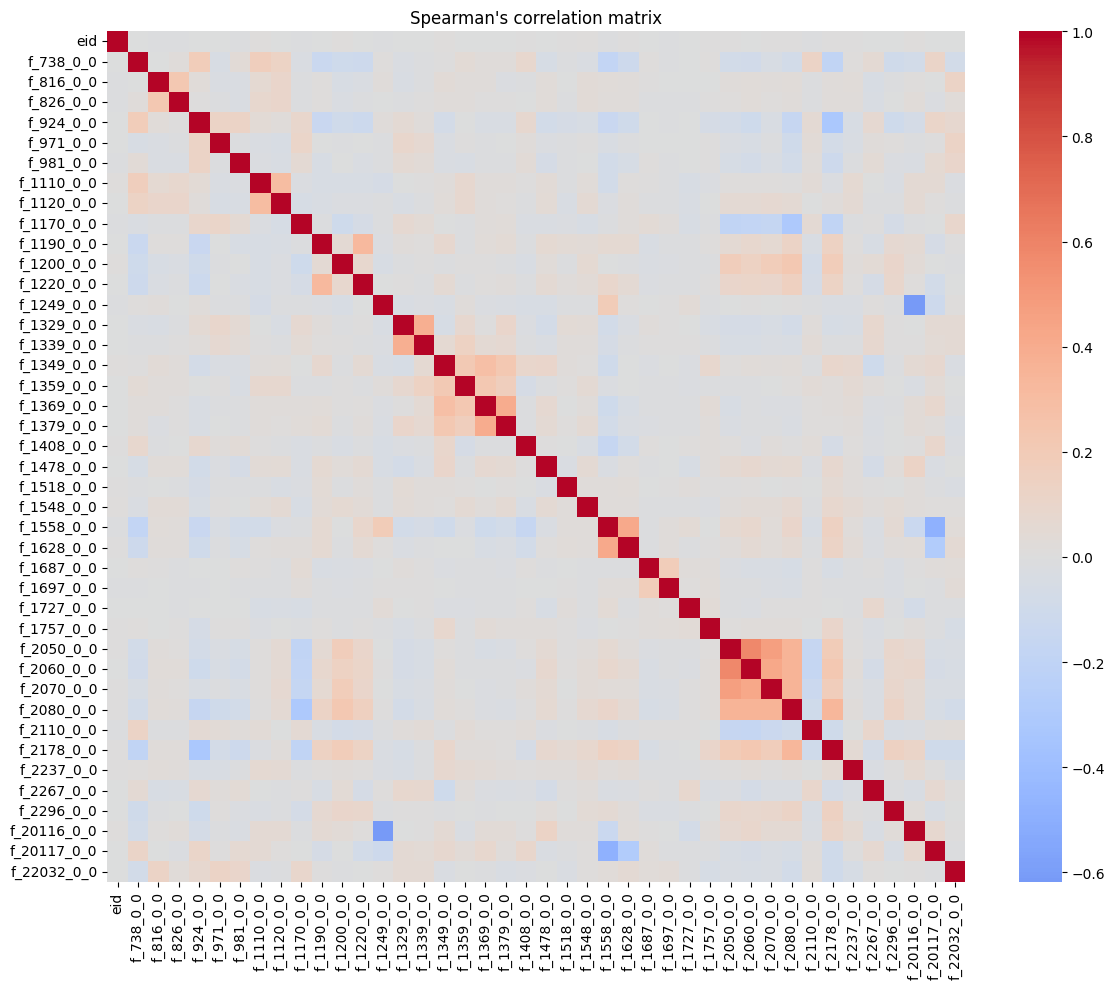

In [20]:
corr_matrix = correlation_matrix_spearman(categorical_simple_ordinal_df)

visualize_correlation_matrix(corr_matrix, title="Spearman's correlation matrix", center=0)

In [21]:
get_highly_correlated_columns_from_matrix(corr_matrix, 
                                          touchscreen_chars_df,
                                          threshold=0.75)


Pairs found with correlation > 0.75: 0
No pairs were found with correlation above the threshold.


Identification of strongly correlated data for nominal categorical data by Cramér's V method.

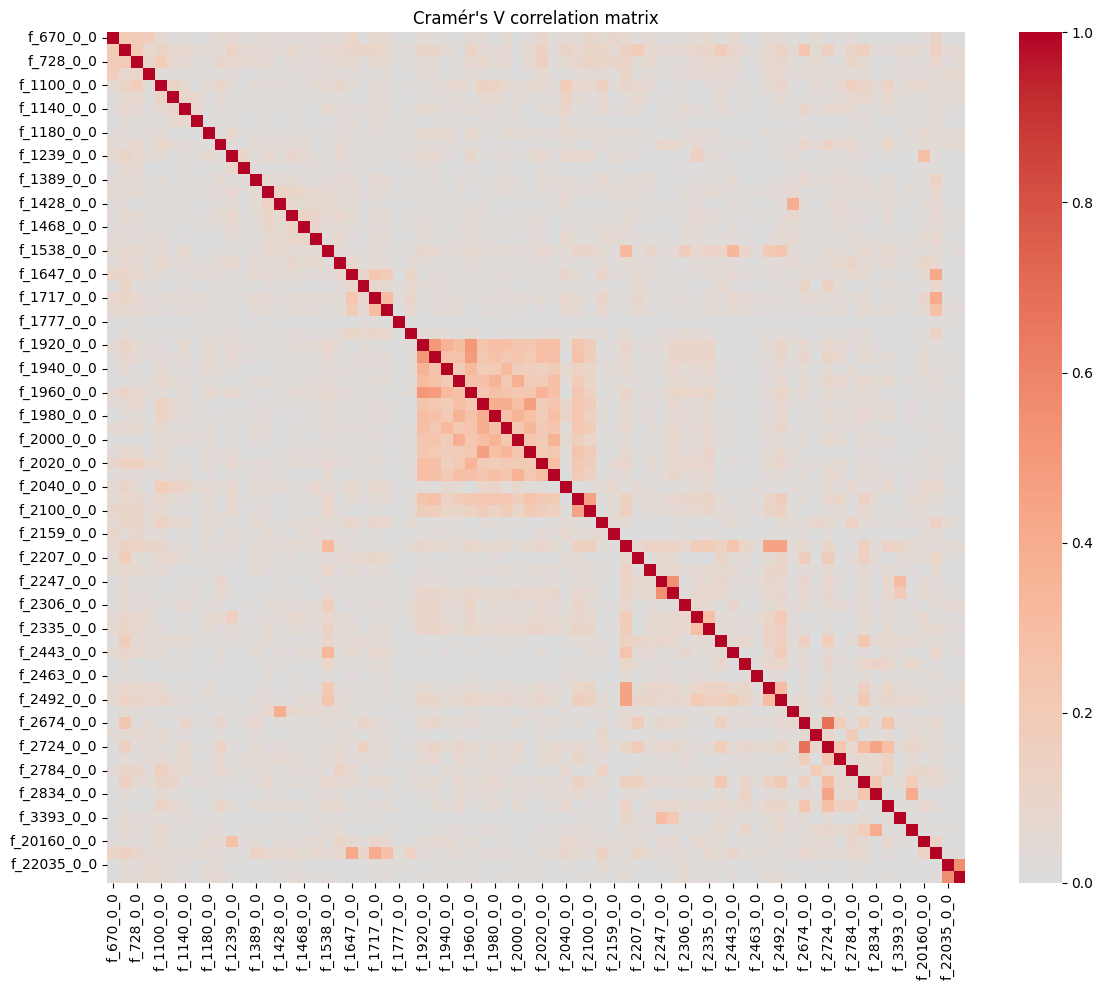

In [22]:
correlation_matrix_crammer_df = correlation_matrix_crammer(categorical_simple_nominal_df)

visualize_correlation_matrix(correlation_matrix_crammer_df, 
                             title="Cramér's V correlation matrix", 
                             center=0)

In [23]:
get_highly_correlated_columns_from_matrix(correlation_matrix_crammer_df, 
                                          touchscreen_chars_df,
                                          0.75)


Pairs found with correlation > 0.75: 0
No pairs were found with correlation above the threshold.


#### Simple nominal categorical data processing

Onehot encoding.

In [24]:
categorical_simple_nominal_onehot_df = onehot_encode_simple_nominal(
    categorical_simple_nominal_df,
    touchscreen_chars_df,
    touchscreen_cbkeys_df
)

categorical_simple_nominal_onehot_df.head()

,eid,f_670_100286_1,f_670_100286_2,f_670_100286_3,f_670_100286_4,f_670_100286_5,f_680_100287_1,f_680_100287_2,f_680_100287_3,f_680_100287_4,...,f_21000_1001_3004,f_21000_1001_4001,f_21000_1001_4002,f_21000_1001_4003,f_21000_1001_5,f_21000_1001_6,f_22035_7_1,f_22035_7_0,f_22036_7_1,f_22036_7_0
0,1000298,1,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,1,0,1,0
1,1000767,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,1,0
2,1000952,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0
3,1001301,0,1,0,0,0,0,0,1,0,...,0,0,0,0,1,0,1,0,1,0
4,1001358,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,1,0


In [25]:
categorical_simple_nominal_onehot_df.shape

(22625, 228)

#### Multiple categorical data processing

In [26]:
categorical_multiple_onehot_df = onehot_encode_multiple_nominal(
    categorical_multiple_df,
    touchscreen_chars_df,
    touchscreen_cbkeys_df)

# Mostrar muestra del resultado
categorical_multiple_onehot_df.head()

/home/angie/Documents/proyecto/colaborativo/Horizontal_UKB/touchscreen/helpers/oneHotEncoding.py:136: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<IntegerArray>
[5, 5, 5, 4, 5, 4, 4, 5, 5, 5,
 ...
 4, 4, 5, 4, 4, 3, 5, 4, 5, 5]
Length: 22625, dtype: Int32' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[:, col] = df[col].astype("Int32")
/home/angie/Documents/proyecto/colaborativo/Horizontal_UKB/touchscreen/helpers/oneHotEncoding.py:136: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<IntegerArray>
[<NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>,
 ...
 <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>]
Length: 22625, dtype: Int32' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[:, col] = df[col].astype("Int32")
/home/angie/Do

,eid,f_6144_100385_1,f_6144_100385_2,f_6144_100385_3,f_6144_100385_4,f_6144_100385_5,f_6146_100510_1,f_6146_100510_2,f_6146_100510_3,f_6147_100514_1,...,f_20111_1010_3,f_20111_1010_4,f_20111_1010_5,f_20111_1010_6,f_20111_1010_8,f_20111_1010_9,f_20111_1010_10,f_20111_1010_11,f_20111_1010_12,f_20111_1010_13
0,1000298,0,0,0,0,1,<NA>,<NA>,<NA>,1,...,0,0,0,0,1,0,0,0,0,0
1,1000767,0,0,0,0,1,<NA>,<NA>,<NA>,<NA>,...,0,0,0,0,1,0,0,0,0,0
2,1000952,0,0,0,0,1,<NA>,<NA>,<NA>,0,...,0,0,0,0,0,0,0,0,0,0
3,1001301,0,0,0,1,0,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4,1001358,0,0,0,0,1,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [27]:
categorical_multiple_onehot_df.shape

(22599, 154)

Elimination de columns with more of 50% of NA's

In [28]:
categorical_multiple_onehot_df = na_elimination(categorical_multiple_onehot_df, 0.5)

categorical_multiple_onehot_df.shape

(22599, 45)

Categorical imputation stratified by multimodal class and by mode.

In [29]:
categorical_multiple_onehot_df = categorical_multiple_onehot_df.merge(ibd0_df[['eid', 'Disease']], on='eid', how='left')

categorical_multiple_onehot_df['Disease'] = categorical_multiple_onehot_df['Disease'].apply(
    lambda x: "IBD" if x in ["CD", "UC", "IBD"] else "Control"
)

categorical_multiple_onehot_df['Disease'].value_counts(dropna=False)

Disease
Control    18978
IBD         3621
Name: count, dtype: int64

In [30]:
categorical_multiple_onehot_df = impute_by_disease(categorical_multiple_onehot_df) 

categorical_multiple_onehot_df.shape

(22599, 46)

#### Numerical data processing

Elimination de columns with more of 50% of NA's

In [31]:
numeric_df = na_elimination(numeric_df, 0.5)

numeric_df.shape

(22625, 47)

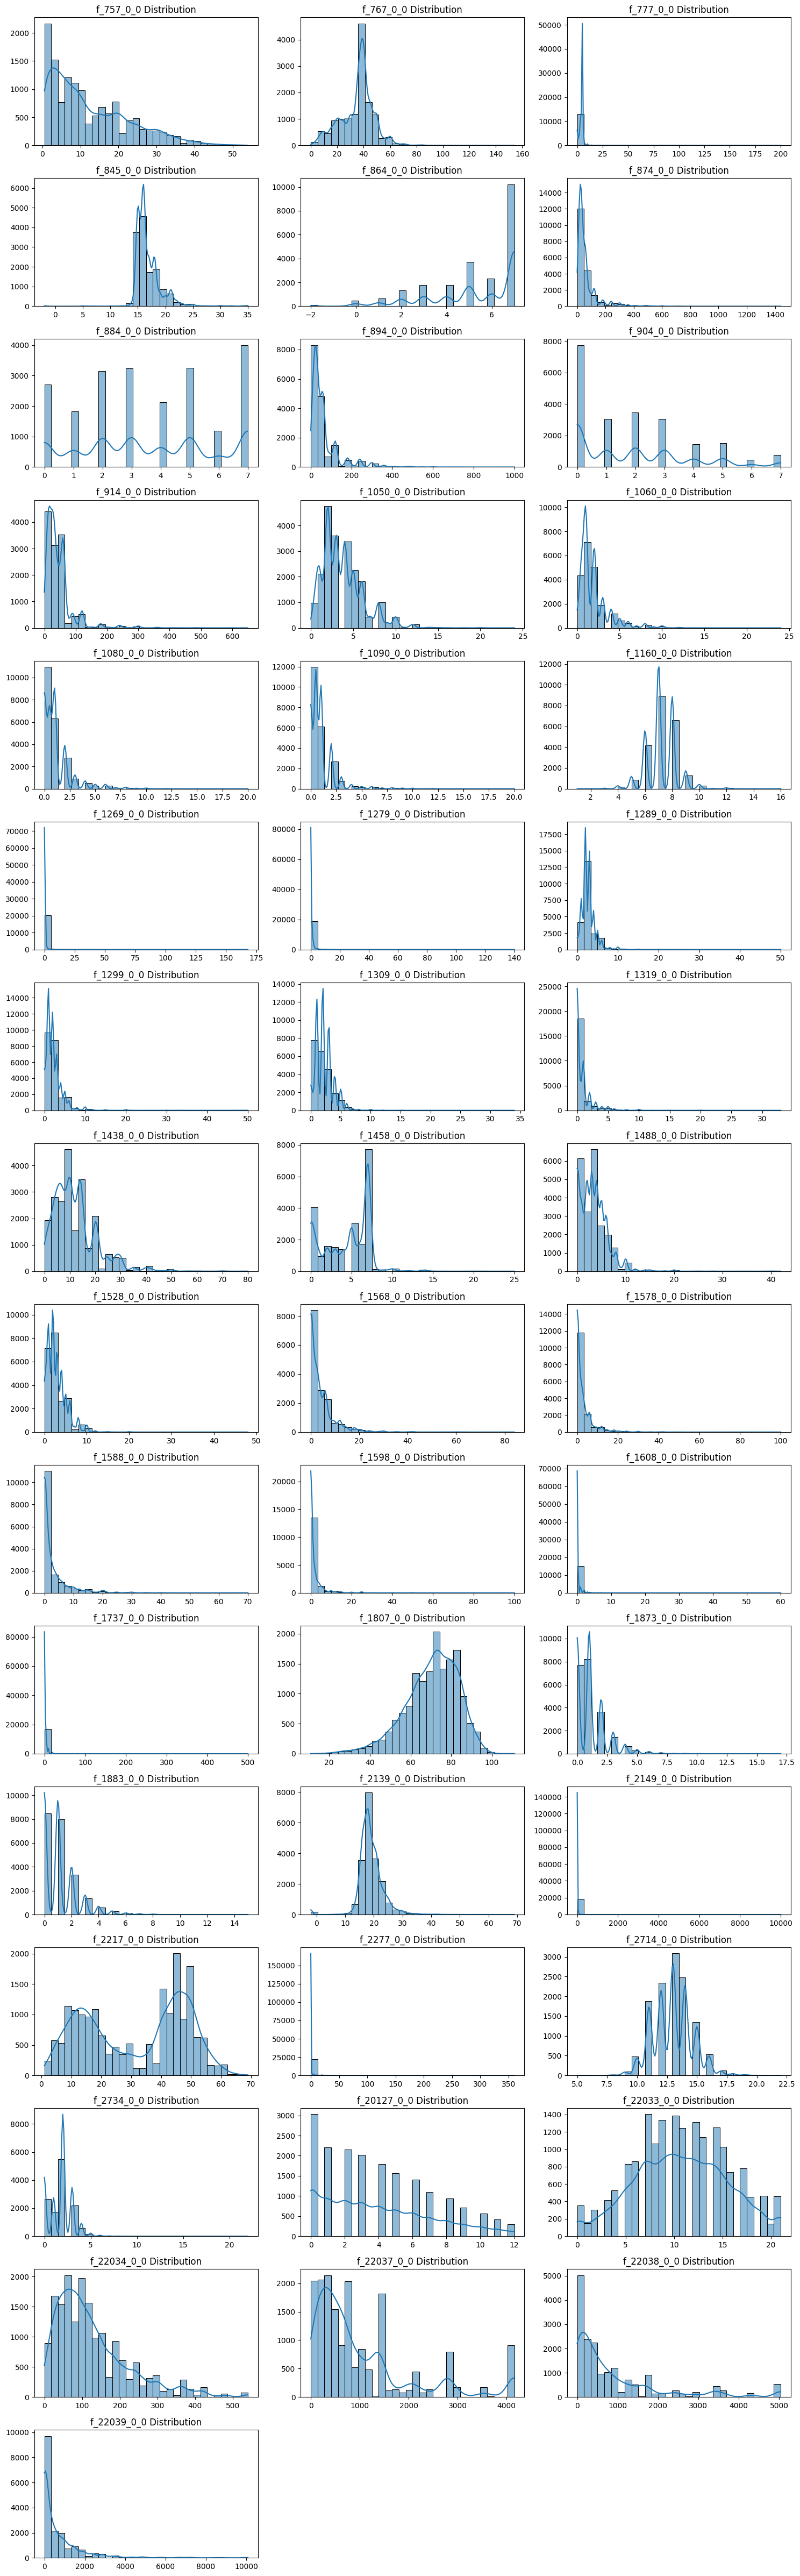

In [32]:
create_histograms(numeric_df, ncols=3)

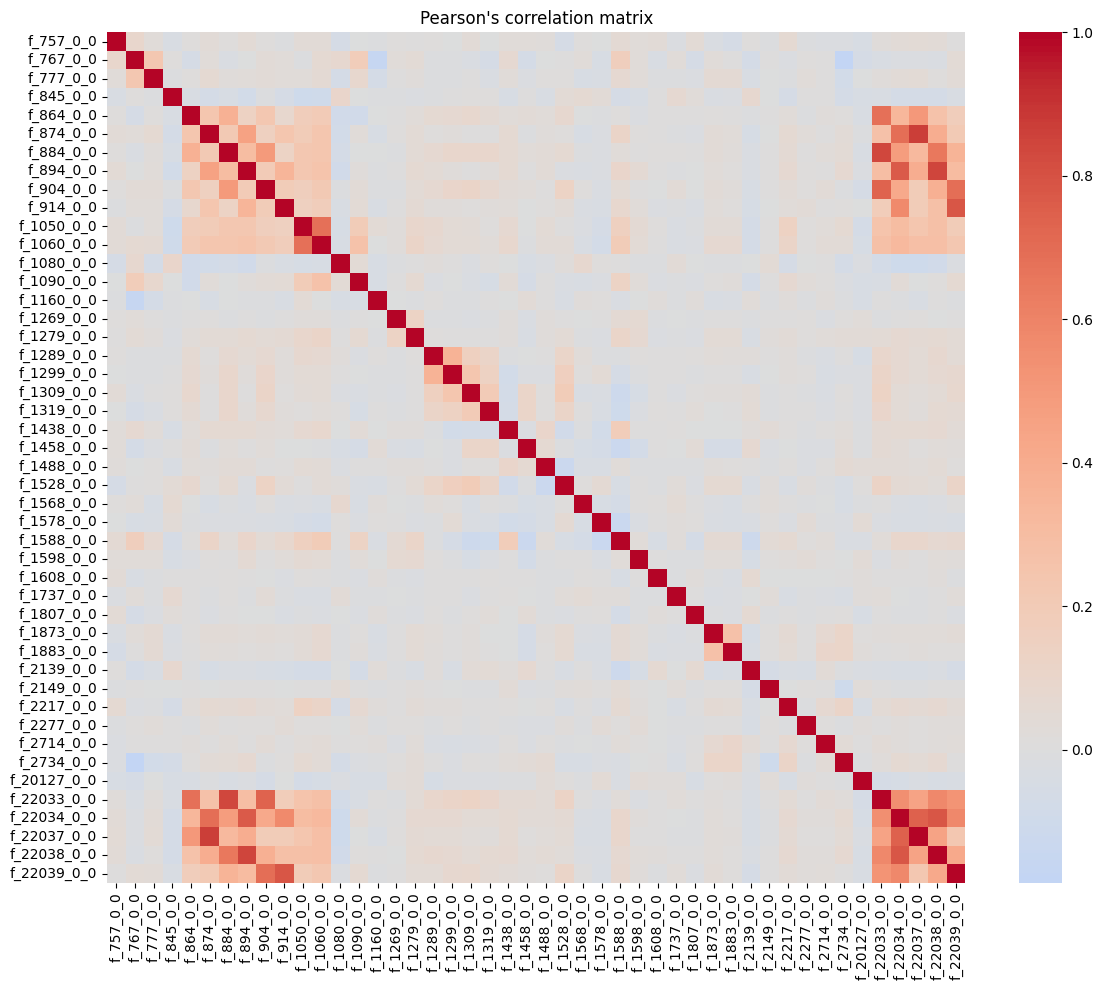

In [33]:
correlation_matrix_numerical = numeric_df.drop(columns='eid').corr()

visualize_correlation_matrix(correlation_matrix_numerical, 
                             title="Pearson's correlation matrix", 
                             center=0)

In [34]:
get_highly_correlated_columns_from_matrix(correlation_matrix_numerical, 
                                          touchscreen_chars_df ,
                                          threshold=0.75)


Pairs found with correlation > 0.75: 6


,Variable1,Variable2,FieldID1,FieldID2,Name1,Name2,correlation
252,f_874_0_0,f_22037_0_0,874,22037,Duration of walks,MET minutes per week for walking,0.868352
330,f_894_0_0,f_22038_0_0,894,22038,Duration of moderate activity,MET minutes per week for moderate activity,0.847422
289,f_884_0_0,f_22033_0_0,884,22033,Number of days/week of moderate physical activ...,Summed days activity,0.833728
404,f_914_0_0,f_22039_0_0,914,22039,Duration of vigorous activity,MET minutes per week for vigorous activity,0.786305
1030,f_22034_0_0,f_22038_0_0,22034,22038,Summed minutes activity,MET minutes per week for moderate activity,0.780324
328,f_894_0_0,f_22034_0_0,894,22034,Duration of moderate activity,Summed minutes activity,0.766395


Elimination of highly related variables

| FiledID | Field                            |
|---------|----------------------------------|
| 22037   | MET minutes per week for walking |
| 22038   | MET minutes per week for moderate activity |
| 884     | Number of days/week of moderate physical activity 10+ minutes |
| 22039   | MET minutes per week for vigorous activity |
| 22038   | MET minutes per week for moderate activity |
| 894     | Duration of moderate activity |

In [35]:
# List of irrelevant Field IDs to drop
irrelevant_ids = [ "22037", "22038", "884", "22039", "894" ]

numeric_df = eliminate_fields_by_fieldID(irrelevant_ids, numeric_df)

numeric_df.shape

(22625, 42)

Verification of highly correlated columns

In [36]:
correlation_matrix_numerical = numeric_df.drop(columns='eid').corr()

get_highly_correlated_columns_from_matrix(correlation_matrix_numerical, 
                                          touchscreen_chars_df ,
                                          threshold=0.75)


Pairs found with correlation > 0.75: 0
No pairs were found with correlation above the threshold.


Boxplots to see outliers

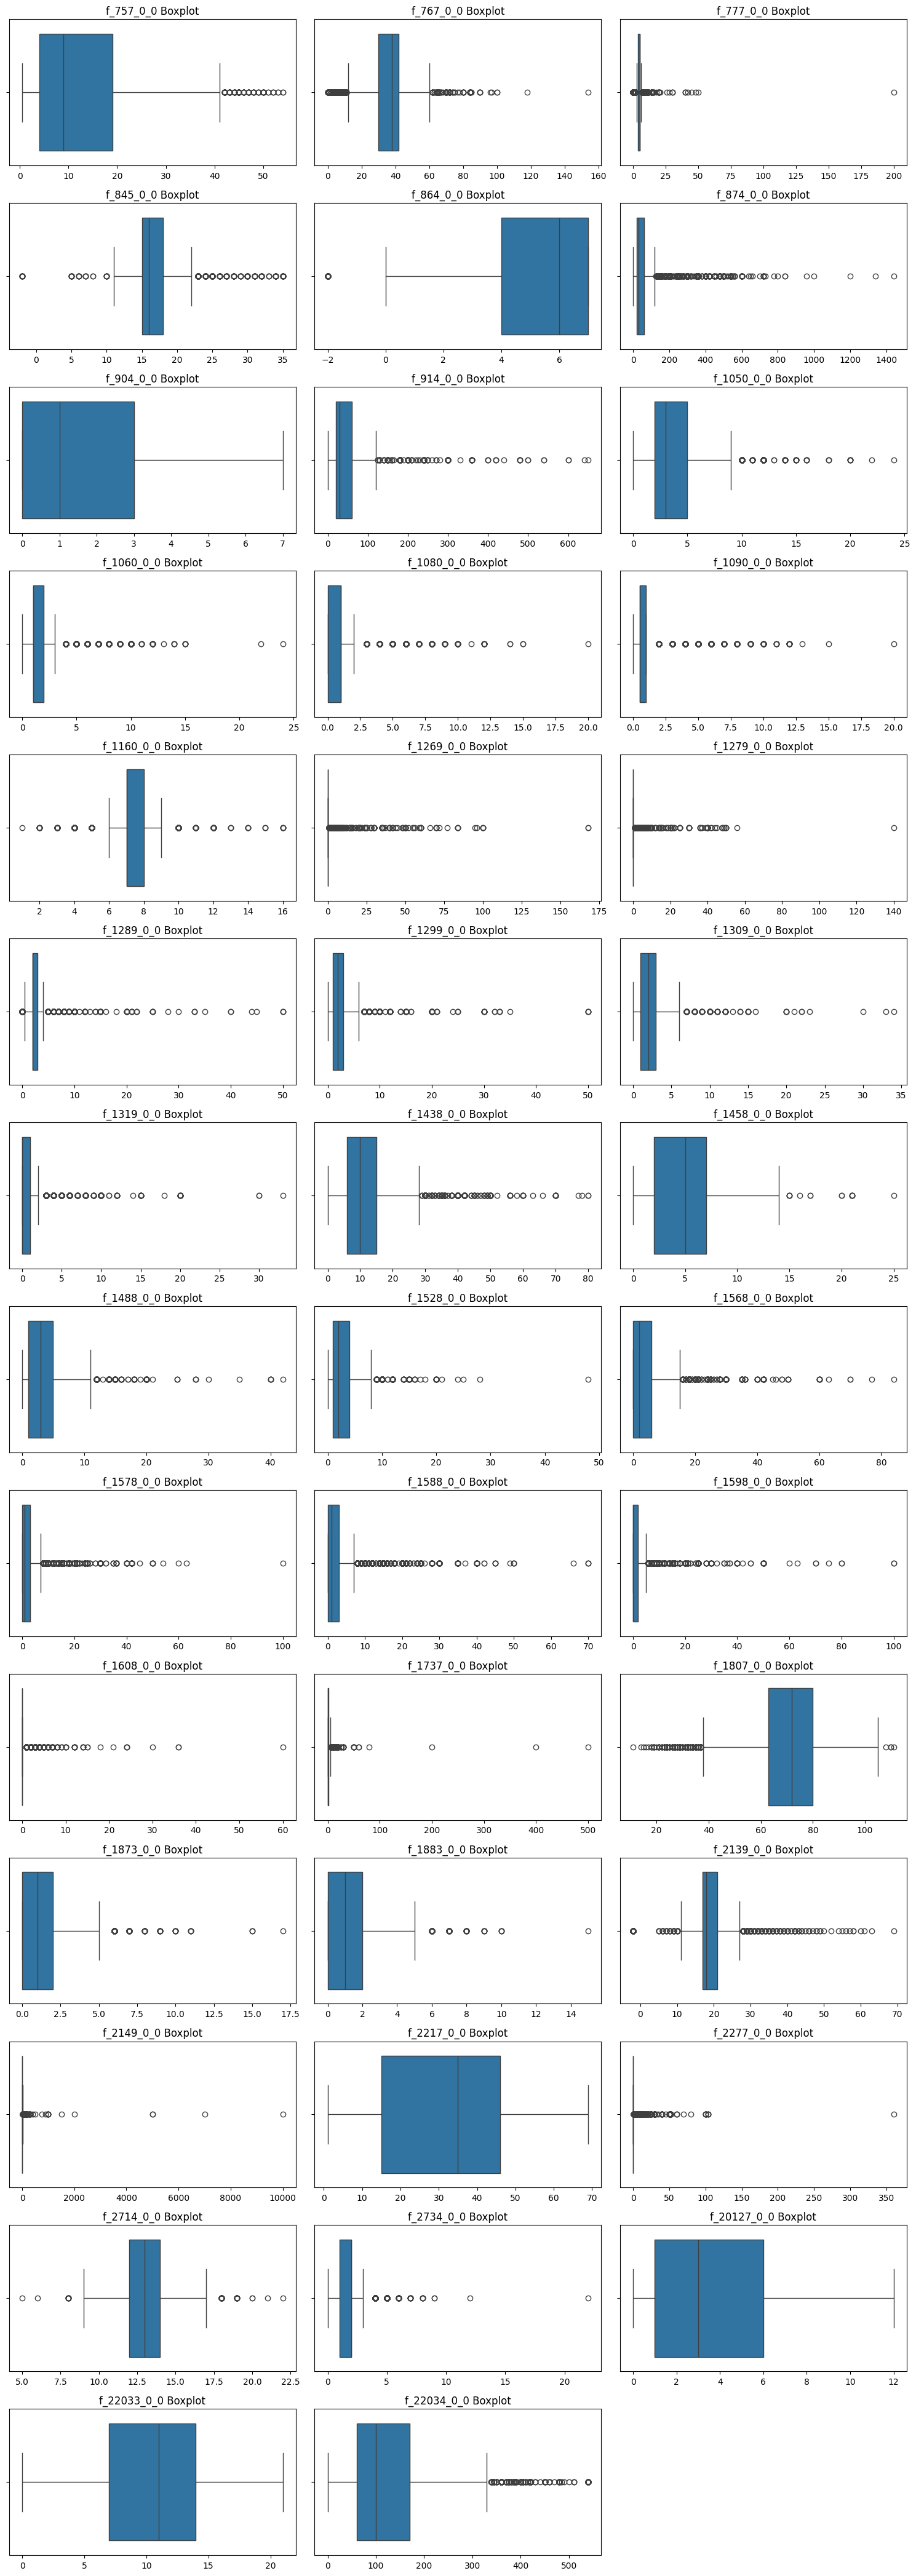

In [37]:
create_boxplots(numeric_df, ncols=3)

Since we are dealing with a data set with a large amount of data and with several dimensions, we decided to use isolation forest for the imputation. For this, we normalize the data and then implement the model to find the outliers and generate two new datasets without the outliers.

In [38]:
numeric_clean_df, cat_mult_clean_df, cat_simple_ordinal_clean_df, cat_simple_nominal_onehot_clean_df = remove_outliers_and_align_datasets(
    numeric_df,
    categorical_multiple_onehot_df,
    categorical_simple_ordinal_df,
    categorical_simple_nominal_onehot_df
)

print(f"Outliers removed: {numeric_df.shape[0] - numeric_clean_df.shape[0]}")
# # Guardamos solo las variables numéricas sin 'eid'
# features_df = numeric_df.drop(columns=['eid'])

# # Escalamos los datos
# scaler = StandardScaler()
# scaled_data = scaler.fit_transform(features_df)

# # Creamos y entrenamos el modelo
# iso_forest = IsolationForest(contamination='auto', random_state=42)
# outlier_labels = iso_forest.fit_predict(scaled_data)

# # Añadimos los resultados a numeric_df
# numeric_df['outlier'] = outlier_labels

# # Obtenemos solo los índices de las filas NO outliers
# valid_indices = numeric_df[numeric_df['outlier'] == 1]['eid']

# # Filtramos ambos DataFrames usando esos 'eid' 
# numeric_df_clean = numeric_df[numeric_df['eid'].isin(valid_indices)].drop(columns='outlier')
# categorical_multiple_onehot_clean_df = categorical_multiple_onehot_df[categorical_multiple_onehot_df['eid'].isin(valid_indices)]
# categorical_simple_ordinal_df_clean = categorical_simple_ordinal_df[categorical_simple_ordinal_df['eid'].isin(valid_indices)]   
# categorical_simple_nominal_onehot_clean_df = categorical_simple_nominal_onehot_df[categorical_simple_nominal_onehot_df['eid'].isin(valid_indices)]

# n_total = numeric_df.shape[0]
# n_removed = n_total - len(valid_indices)
# print(f'Se eliminaron {n_removed} outliers de un total de {n_total} filas.')

Outliers removed: 1156


New distribution and boxplot visualization

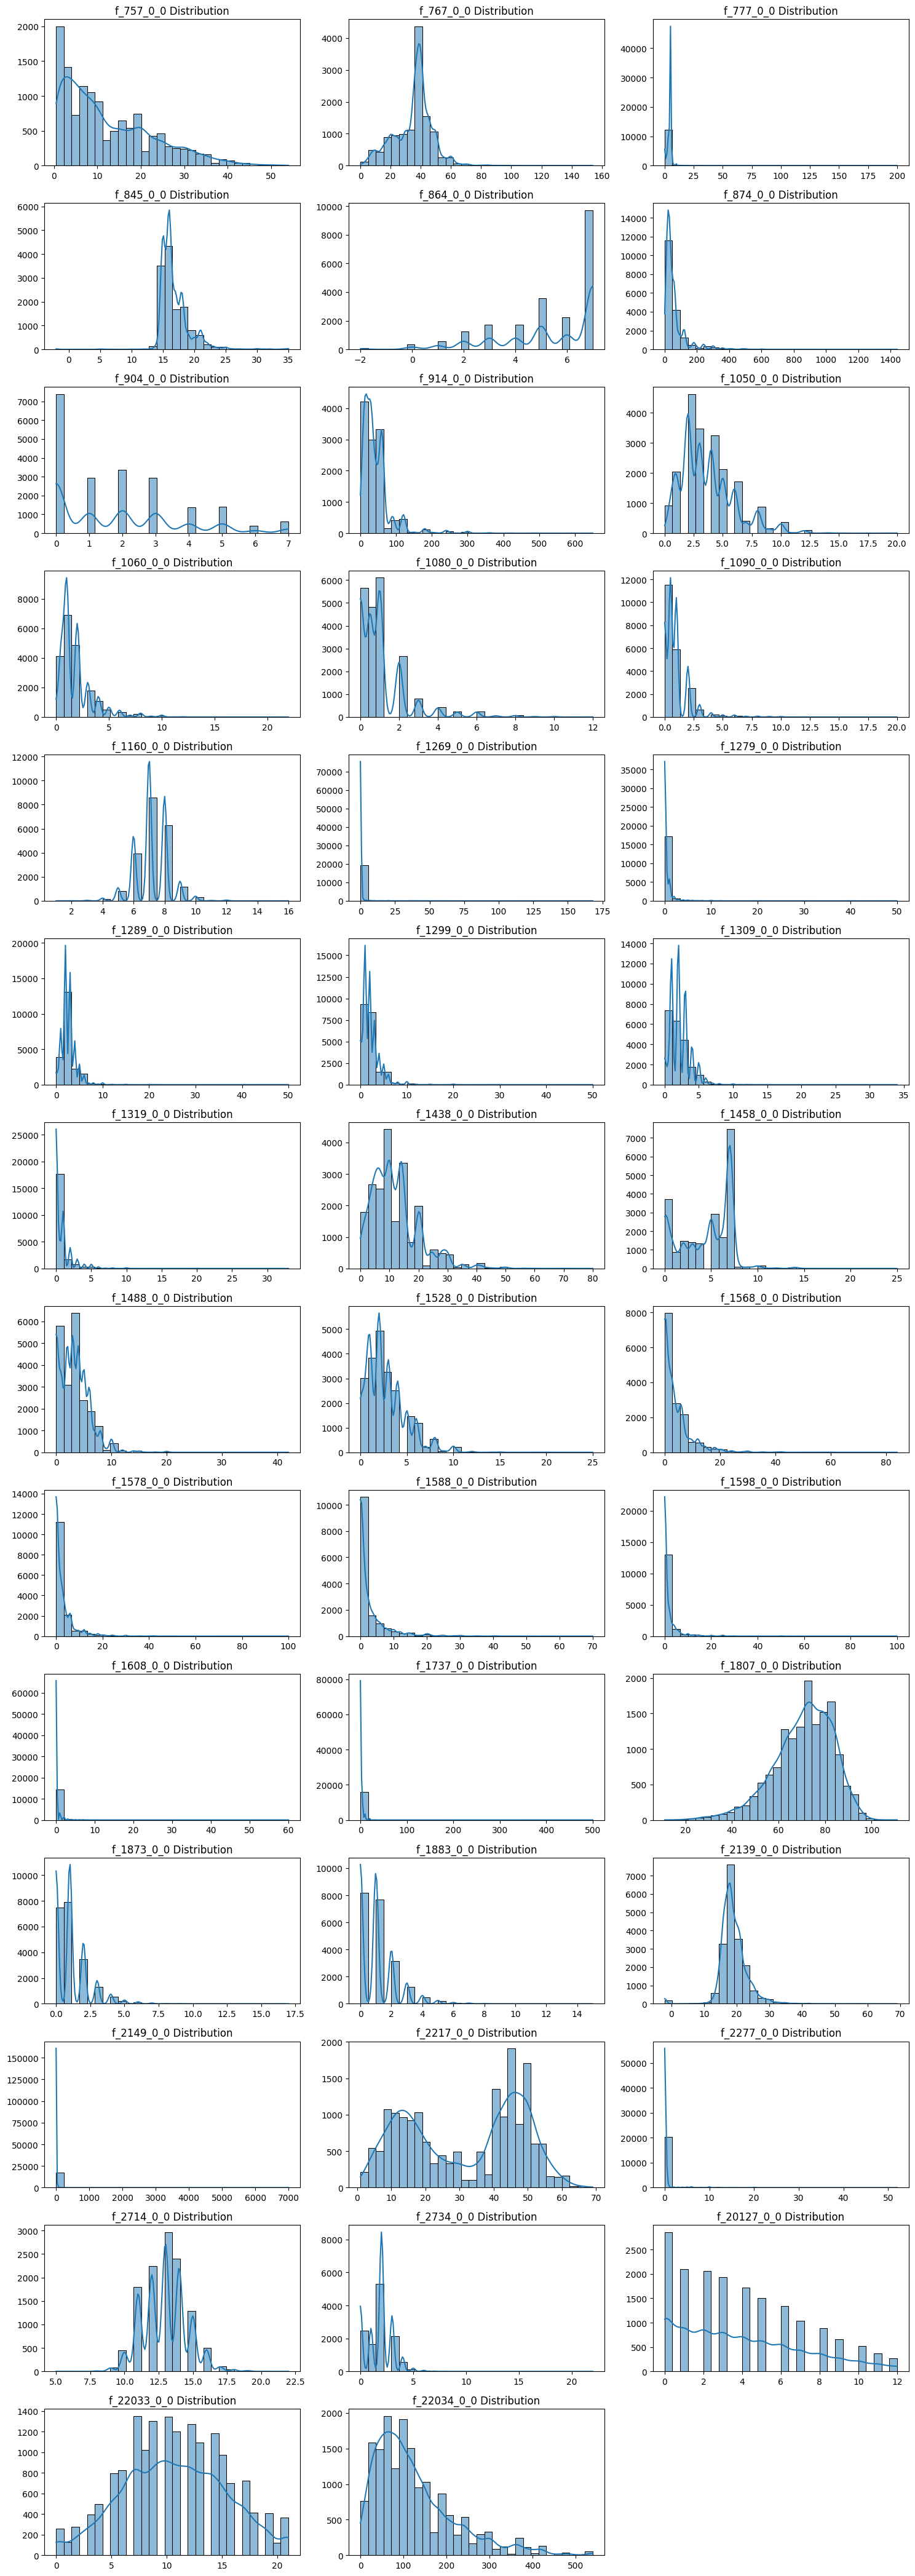

In [39]:
create_histograms(numeric_clean_df, ncols=3)

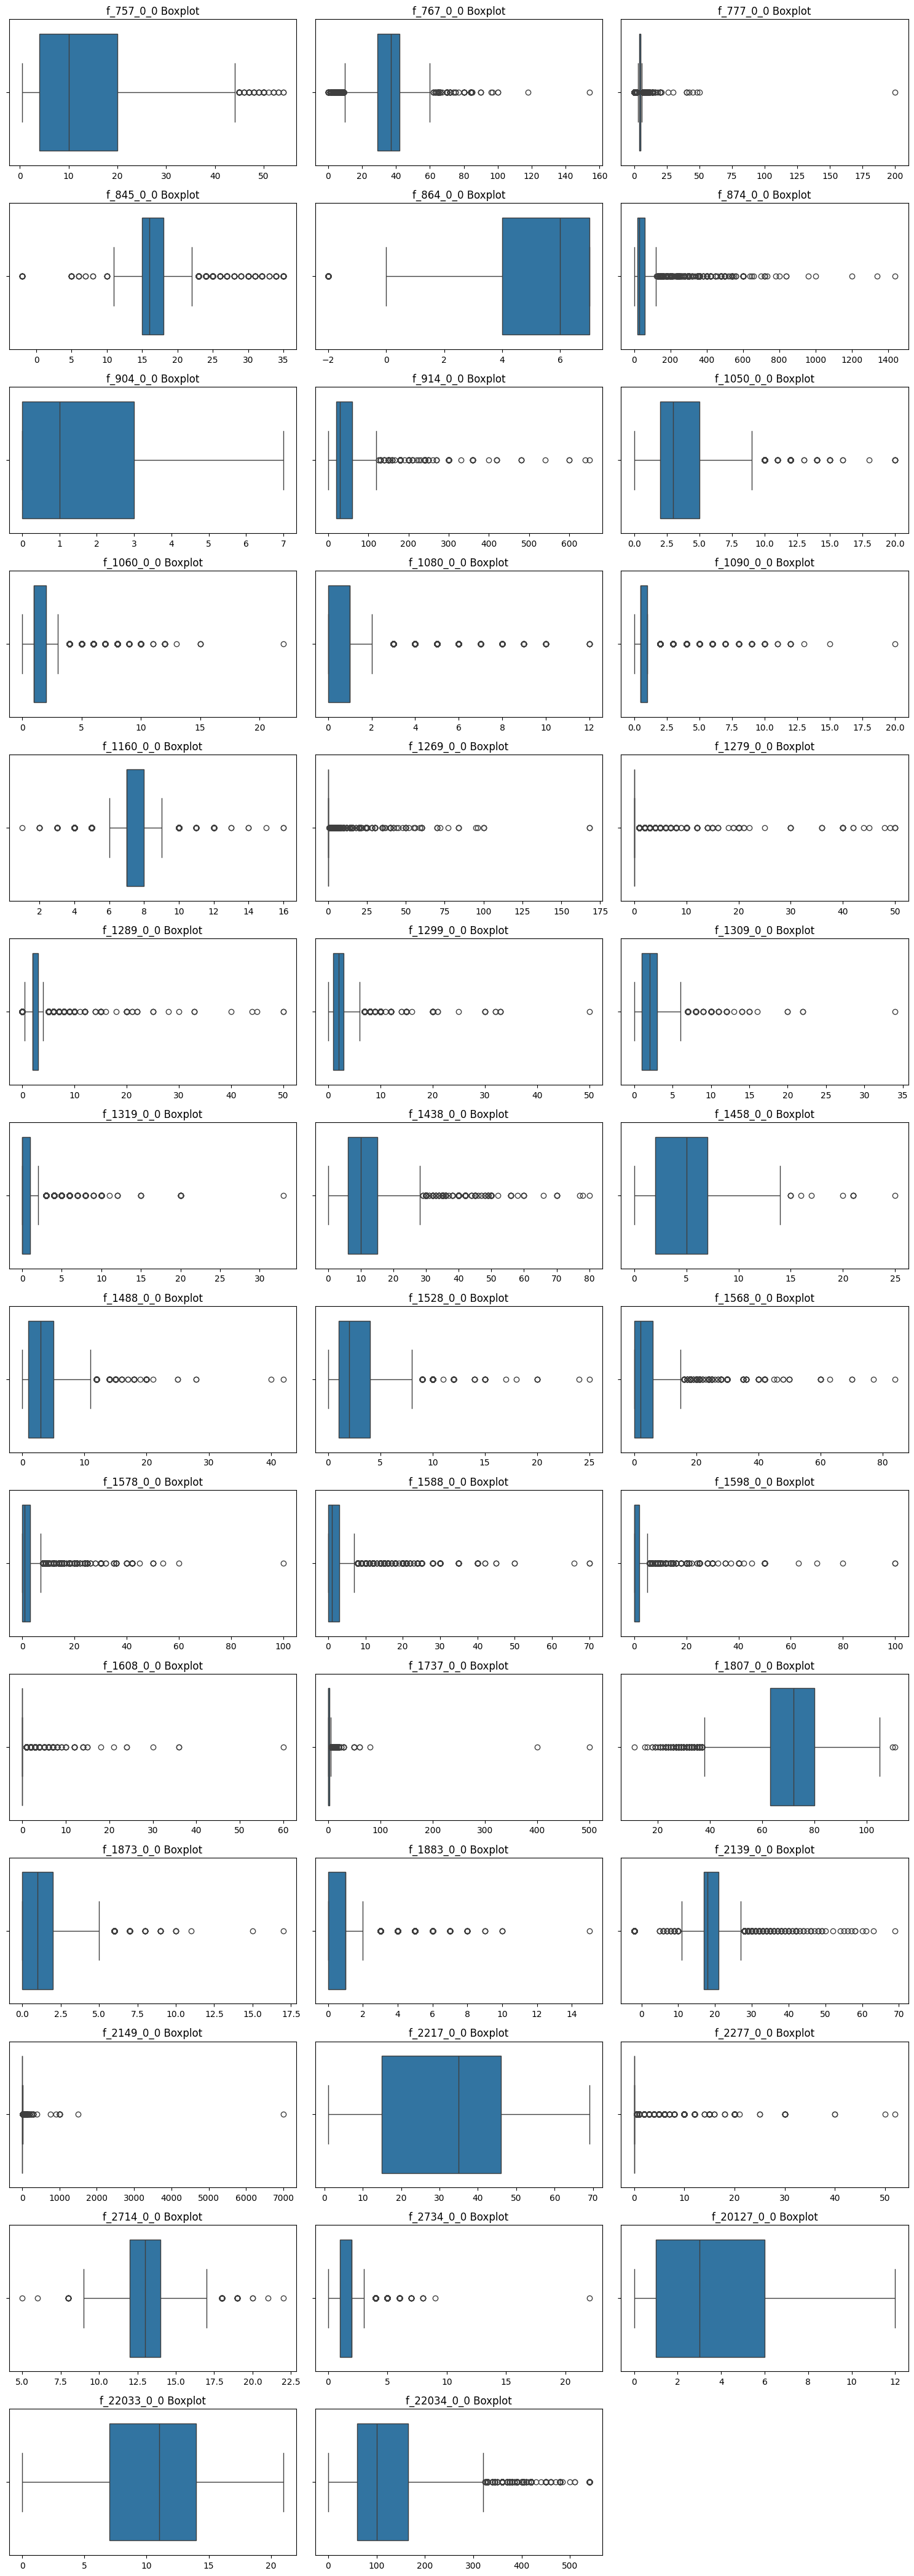

In [40]:
create_boxplots(numeric_clean_df, ncols=3)

Categorical imputation stratified by multimodal class and by mode.

In [41]:
numeric_clean_df = numeric_clean_df.merge(ibd0_df[['eid', 'Disease']], on='eid', how='left')

numeric_clean_df['Disease'] = numeric_clean_df['Disease'].apply(
    lambda x: "IBD" if x in ["CD", "UC", "IBD"] else "Control"
)

numeric_clean_df['Disease'].value_counts(dropna=False)

Disease
Control    18065
IBD         3404
Name: count, dtype: int64

In [ ]:
numeric_clean_df = impute_by_disease(numeric_clean_df)
numeric_clean_df.shape

(21469, 43)

Exception ignored in: <function ResourceTracker.__del__ at 0x7f048e590540>
Traceback (most recent call last):
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7ff177e80540>
Traceback (most recent call last):
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7f3007b8c540>
Traceback (most recent call last):
  File "/usr/lib64/python3.13/multip

Scaling and standardization of numerical data

In [43]:
#Escale
touchscreen_numeric_scaled = scale_numeric_columns(numeric_clean_df)
    
touchscreen_numeric_standard = scale_numeric_columns(touchscreen_numeric_scaled)

touchscreen_numeric_standard.head()

,eid,f_757_0_0,f_767_0_0,f_777_0_0,f_845_0_0,f_864_0_0,f_874_0_0,f_904_0_0,f_914_0_0,f_1050_0_0,...,f_1883_0_0,f_2139_0_0,f_2149_0_0,f_2217_0_0,f_2277_0_0,f_2714_0_0,f_2734_0_0,f_20127_0_0,f_22033_0_0,f_22034_0_0
0,1000298,-0.661411,0.280010,0.204728,-0.239500,0.306126,-0.498011,1.708609,-0.940307,-0.680984,...,0.855141,1.984046,-0.074940,0.390319,-0.155966,0.011997,0.138040,-0.655859,1.383475,-0.489386
1,1000767,-0.661411,0.280010,0.204728,1.228335,-1.246000,-0.352754,0.132533,-1.247643,-0.680984,...,-0.005896,0.514180,0.018770,0.328559,-0.155966,0.011997,0.138040,-0.039908,0.028104,-0.489386
2,1000952,0.395042,-0.024716,0.204728,1.717613,0.823502,-0.352754,-0.918185,0.289037,-1.353954,...,0.855141,-0.220753,-0.093682,0.822645,-0.155966,0.845557,1.224399,-0.963835,-0.649581,-0.605685
3,1001301,-0.450121,1.295763,0.689432,-0.239500,-2.280751,-0.352754,-0.392826,0.289037,-1.129630,...,-0.866932,-0.220753,-0.093682,0.699123,-0.155966,0.011997,0.138040,2.731871,-0.649581,-0.605685
4,1001358,1.028914,-0.024716,0.204728,-0.239500,-1.763376,0.083018,-0.392826,-1.247643,-1.129630,...,-0.005896,0.759158,0.000028,0.699123,-0.155966,0.011997,0.138040,0.268067,-1.101372,0.208410


## Data set assembly

In [ ]:
# def rename_columns_with_field_names(df, touchscreen_chars_df, exclude_cols=['eid', 'Disease']):
#     touchscreen_chars_df = touchscreen_chars_df.dropna(subset=['FieldID', 'Field']).copy()
#     touchscreen_chars_df['FieldID'] = touchscreen_chars_df['FieldID'].astype(int)
#     touchscreen_chars_df['Field'] = touchscreen_chars_df['Field'].str.strip()

#     fieldid_to_name = dict(zip(touchscreen_chars_df['FieldID'], touchscreen_chars_df['Field']))

#     rename_dict = {}
#     for col in df.columns:
#         if col in exclude_cols:
#             continue

#         match = re.match(r'f_(\d+)_\d+_\d+', col)
#         if match:
#             fieldid = int(match.group(1))
#             new_name = fieldid_to_name.get(fieldid)
#             if new_name:
#                 rename_dict[col] = new_name
#             else:
#                 print(f"FieldID {fieldid} encontrado en columna '{col}' no está en touchscreen_chars_df")
#         else:
#             print(f"No coincide con patrón: {col}")

#     return df.rename(columns=rename_dict)


In [44]:
touchscreen_chars_df = pd.read_csv(
    os.path.join(inputpath, 'touchscreen_chars.tsv'),
    sep="\t",
    skiprows=5
)

# Mostrar las primeras filas
touchscreen_chars_df.head()

,Field,FieldID,ValueType,Coding,Category,Participants,Items,Stability,Units,ItemType,Strata,Sexed,Instances,Array,Notes,Link,Path
0,Type of accommodation lived in,670,Categorical single,100286.0,100066,501527,597706,Complete,NaN,Data,Primary,Unisex,4,1,"ACE touchscreen question """"""""What type of acco...",http://biobank.ndph.ox.ac.uk/ukb/field.cgi?id=670,Assessment centre > Touchscreen > Sociodemogra...
1,Own or rent accommodation lived in,680,Categorical single,100287.0,100066,500149,596187,Complete,NaN,Data,Primary,Unisex,4,1,"ACE touchscreen question """"""""Do you own or ren...",http://biobank.ndph.ox.ac.uk/ukb/field.cgi?id=680,Assessment centre > Touchscreen > Sociodemogra...
2,Length of time at current address,699,Integer,100290.0,100066,501523,597702,Complete,years,Data,Primary,Unisex,4,1,"ACE touchscreen question """"""""How many years ha...",http://biobank.ndph.ox.ac.uk/ukb/field.cgi?id=699,Assessment centre > Touchscreen > Sociodemogra...
3,Number in household,709,Integer,100291.0,100066,500147,596185,Complete,people,Data,Primary,Unisex,4,1,"ACE touchscreen question """"""""Including yoursel...",http://biobank.ndph.ox.ac.uk/ukb/field.cgi?id=709,Assessment centre > Touchscreen > Sociodemogra...
4,Number of vehicles in household,728,Categorical single,100293.0,100066,500147,596185,Complete,NaN,Data,Primary,Unisex,4,1,"ACE touchscreen question """"""""How many cars or ...",http://biobank.ndph.ox.ac.uk/ukb/field.cgi?id=728,Assessment centre > Touchscreen > Sociodemogra...


In [45]:
transformed_ordinal= rename_columns_with_field_names(
    cat_simple_ordinal_clean_df, 
    touchscreen_chars_df)
transformed_ordinal.head()

,eid,Average total household income before tax,Job involves heavy manual or physical work,Job involves shift work,Usual walking pace,Frequency of walking for pleasure in last 4 weeks,Duration walking for pleasure,Length of mobile phone use,Weekly usage of mobile phone in last 3 months,Getting up in morning,...,Frequency of tiredness / lethargy in last 2 weeks,Able to confide,Overall health rating,Plays computer games,Use of sun/uv protection,Falls in the last year,Smoking status,Alcohol drinker status,IPAQ activity group,Disease
0,1000298,2,1,1,3,2,3,5,0,4,...,1,2,1,0,1,1,1,2,2,Control
1,1000767,3,1,1,3,2,6,5,3,4,...,1,5,1,1,2,1,0,2,1,IBD
2,1000952,3,2,2,1,2,3,5,1,3,...,2,4,3,1,5,2,0,0,2,Control
3,1001301,3,2,1,2,2,5,5,1,3,...,4,0,3,0,1,1,1,2,2,Control
4,1001358,2,1,1,3,2,3,3,3,2,...,1,5,1,1,3,1,0,2,1,Control


In [46]:
transformed_numerical = rename_columns_with_field_names(
    touchscreen_numeric_standard, 
    touchscreen_chars_df)
transformed_numerical.head()

,eid,Time employed in main current job,Length of working week for main job,Frequency of travelling from home to job workplace,Age completed full time education,Number of days/week walked 10+ minutes,Duration of walks,Number of days/week of vigorous physical activity 10+ minutes,Duration of vigorous activity,Time spend outdoors in summer,...,Number of full sisters,Age first had sexual intercourse,Lifetime number of sexual partners,Age started wearing glasses or contact lenses,Frequency of solarium/sunlamp use,Age when periods started (menarche),Number of live births,Neuroticism score,Summed days activity,Summed minutes activity
0,1000298,-0.661411,0.280010,0.204728,-0.239500,0.306126,-0.498011,1.708609,-0.940307,-0.680984,...,0.855141,1.984046,-0.074940,0.390319,-0.155966,0.011997,0.138040,-0.655859,1.383475,-0.489386
1,1000767,-0.661411,0.280010,0.204728,1.228335,-1.246000,-0.352754,0.132533,-1.247643,-0.680984,...,-0.005896,0.514180,0.018770,0.328559,-0.155966,0.011997,0.138040,-0.039908,0.028104,-0.489386
2,1000952,0.395042,-0.024716,0.204728,1.717613,0.823502,-0.352754,-0.918185,0.289037,-1.353954,...,0.855141,-0.220753,-0.093682,0.822645,-0.155966,0.845557,1.224399,-0.963835,-0.649581,-0.605685
3,1001301,-0.450121,1.295763,0.689432,-0.239500,-2.280751,-0.352754,-0.392826,0.289037,-1.129630,...,-0.866932,-0.220753,-0.093682,0.699123,-0.155966,0.011997,0.138040,2.731871,-0.649581,-0.605685
4,1001358,1.028914,-0.024716,0.204728,-0.239500,-1.763376,0.083018,-0.392826,-1.247643,-1.129630,...,-0.005896,0.759158,0.000028,0.699123,-0.155966,0.011997,0.138040,0.268067,-1.101372,0.208410


In [ ]:
# def rename_onehot_columns(df, touchscreen_chars_df, touchscreen_cbkeys_df, exclude_cols=['eid']):
#     """
#     Renombra columnas one-hot codificadas con formato f_<FieldID>_<Coding>_<Code> 
#     usando nombres legibles de preguntas y significados de códigos.

#     Parámetros:
#     - df: DataFrame con columnas one-hot.
#     - touchscreen_chars_df: contiene 'FieldID', 'Field', y 'Coding'.
#     - touchscreen_cbkeys_df: contiene 'coding_name', 'code', 'meaning'.
#     - exclude_cols: columnas a dejar sin cambio, como 'eid'.

#     Retorna:
#     - Un nuevo DataFrame con las columnas renombradas.
#     """

#     # Diccionario FieldID → Field (nombre de la pregunta)
#     fieldid_to_name = {
#         int(row['FieldID']): row['Field']
#         for _, row in touchscreen_chars_df.dropna(subset=['FieldID', 'Field']).iterrows()
#     }

#     # Diccionario (coding_name, code) → meaning
#     coding_code_to_meaning = {
#         (int(row['coding_name']), int(row['code'])): str(row['meaning'])
#         for _, row in touchscreen_cbkeys_df.dropna(subset=['coding_name', 'code', 'meaning']).iterrows()
#     }

#     rename_dict = {}

#     for col in df.columns:
#         if col in exclude_cols:
#             continue

#         match = re.match(r'f_(\d+)_(\d+)_(\d+)', col)
#         if not match:
#             continue

#         fieldid, coding, code = map(int, match.groups())
#         question = fieldid_to_name.get(fieldid, f"Field_{fieldid}")
#         meaning = coding_code_to_meaning.get((coding, code), f"Code_{code}")

#         # Formato final: Pregunta: Respuesta
#         new_col = f"{question}: {meaning}"
#         rename_dict[col] = new_col

#     return df.rename(columns=rename_dict)

In [47]:
transformed_categorical_nominal = rename_onehot_columns(
    cat_simple_nominal_onehot_clean_df,  
    touchscreen_chars_df, 
    touchscreen_cbkeys_df
)
transformed_categorical_nominal.head()

,eid,Type of accommodation lived in: A house or bungalow,"Type of accommodation lived in: A flat, maisonette or apartment",Type of accommodation lived in: Mobile or temporary structure (i.e. caravan),Type of accommodation lived in: Sheltered accommodation,Type of accommodation lived in: Care home,Own or rent accommodation lived in: Own outright (by you or someone in your household),Own or rent accommodation lived in: Own with a mortgage,"Own or rent accommodation lived in: Rent - from local authority, local council, housing association",Own or rent accommodation lived in: Rent - from private landlord or letting agency,...,Ethnic background: Any other Asian background,Ethnic background: Caribbean,Ethnic background: African,Ethnic background: Any other Black background,Ethnic background: Chinese,Ethnic background: Other ethnic group,At or above moderate/vigorous recommendation: Yes,At or above moderate/vigorous recommendation: No,At or above moderate/vigorous/walking recommendation: Yes,At or above moderate/vigorous/walking recommendation: No
0,1000298,1,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,1,0,1,0
1,1000767,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,1,0
2,1000952,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0
3,1001301,0,1,0,0,0,0,0,1,0,...,0,0,0,0,1,0,1,0,1,0
4,1001358,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,1,0


In [48]:
transformed_categorical_multiple = rename_onehot_columns(
    cat_mult_clean_df, 
    touchscreen_chars_df, 
    touchscreen_cbkeys_df
)
transformed_categorical_multiple.head()

,eid,"Never eat eggs, dairy, wheat, sugar: Eggs or foods containing eggs","Never eat eggs, dairy, wheat, sugar: Dairy products","Never eat eggs, dairy, wheat, sugar: Wheat products","Never eat eggs, dairy, wheat, sugar: Sugar or foods/drinks containing sugar","Never eat eggs, dairy, wheat, sugar: I eat all of the above",Pain type(s) experienced in last month: Headache,Pain type(s) experienced in last month: Facial pain,Pain type(s) experienced in last month: Neck or shoulder pain,Pain type(s) experienced in last month: Back pain,...,Illnesses of mother: Lung cancer,Illnesses of mother: Bowel cancer,Illnesses of mother: Breast cancer,Illnesses of mother: Chronic bronchitis/emphysema,Illnesses of mother: High blood pressure,Illnesses of mother: Diabetes,Illnesses of mother: Alzheimer's disease/dementia,Illnesses of mother: Parkinson's disease,Illnesses of mother: Severe depression,Disease
0,1000298,0,0,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,Control
1,1000767,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,IBD
2,1000952,0,0,0,0,1,1,0,1,0,...,0,1,0,0,0,0,1,0,0,Control
3,1001301,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,Control
4,1001358,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Control


In [ ]:
# def merge_dataframes_on_eid(dataframes, disease_source_df=None):
#     """
#     Une múltiples DataFrames por 'eid' usando outer join.
#     Si disease_source_df se proporciona, añade la columna 'Disease' después del merge.
#     """

#     for i, df in enumerate(dataframes):
#         if 'eid' not in df.columns:
#             raise ValueError(f"DataFrame {i} no contiene la columna 'eid'.")
#         df['eid'] = df['eid'].astype('int64')

#     if disease_source_df is not None:
#         disease_source_df['eid'] = disease_source_df['eid'].astype('int64')

#     merged_df = reduce(
#         lambda left, right: pd.merge(left, right, on='eid', how='outer'),
#         dataframes
#     )

#     if disease_source_df is not None:
#         merged_df = merged_df.merge(
#             disease_source_df[['eid', 'Disease']],
#             on='eid',
#             how='left'
#         )

#     return merged_df

In [49]:
dataframes = [
    transformed_categorical_multiple,
    transformed_categorical_nominal,
    transformed_numerical,
    transformed_ordinal
]



full_dataset = merge_dataframes_on_eid(dataframes)

#Guardar en memo
full_dataset.to_csv(os.path.join(inputpath, "touchscreen_data_ready.csv"))

# Modelos

In [50]:
# Phenotypes
touchscreen_final= pd.read_csv(os.path.join(inputpath, "touchscreen_data_ready.csv"))

# Eliminar la columna 'condicion'
#touchscreen_final = touchscreen_final.drop('Disease_y', axis=1)
#pheno_final


touchscreen_final.head()

touchscreen_final = touchscreen_final.merge(ibd0_df[['eid', 'Disease']], on='eid', how='left')

#phenotypes_df_imputed["Condition"] = phenotypes_df_imputed["Disease"].apply(lambda x: "IBD" if x in ["CD", "UC", "IBD"] else "Control")
touchscreen_final["Condition"] = touchscreen_final["Disease"].apply(lambda x: "IBD" if x in ["CD", "UC", "IBD"] else "Control")

In [51]:
touchscreen_final.head()

,Unnamed: 0,eid,"Never eat eggs, dairy, wheat, sugar: Eggs or foods containing eggs","Never eat eggs, dairy, wheat, sugar: Dairy products","Never eat eggs, dairy, wheat, sugar: Wheat products","Never eat eggs, dairy, wheat, sugar: Sugar or foods/drinks containing sugar","Never eat eggs, dairy, wheat, sugar: I eat all of the above",Pain type(s) experienced in last month: Headache,Pain type(s) experienced in last month: Facial pain,Pain type(s) experienced in last month: Neck or shoulder pain,...,Overall health rating,Plays computer games,Use of sun/uv protection,Falls in the last year,Smoking status,Alcohol drinker status,IPAQ activity group,Disease_y,Disease,Condition
0,0,1000298,0,0,0,0,1,0,0,1,...,1,0,1,1,1,2,2,Control,Control,Control
1,1,1000767,0,0,0,0,1,0,0,0,...,1,1,2,1,0,2,1,IBD,IBD,IBD
2,2,1000952,0,0,0,0,1,1,0,1,...,3,1,5,2,0,0,2,Control,Control,Control
3,3,1001301,0,0,0,1,0,1,0,0,...,3,0,1,1,1,2,2,Control,Control,Control
4,4,1001358,0,0,0,0,1,0,0,0,...,1,1,3,1,0,2,1,Control,Control,Control


In [52]:
touchscreen_final.dtypes

Unnamed: 0                                                             int64
eid                                                                    int64
Never eat eggs, dairy, wheat, sugar: Eggs or foods containing eggs     int64
Never eat eggs, dairy, wheat, sugar: Dairy products                    int64
Never eat eggs, dairy, wheat, sugar: Wheat products                    int64
                                                                       ...  
Alcohol drinker status                                                 int64
IPAQ activity group                                                    int64
Disease_y                                                             object
Disease                                                               object
Condition                                                             object
Length: 359, dtype: object

In [53]:
touchscreen_final = touchscreen_final.drop(columns=['Disease', 'Disease_y'])

In [54]:
touchscreen_final['Condition'].unique()


array(['Control', 'IBD'], dtype=object)

In [55]:
touchscreen_final.dtypes

Unnamed: 0                                                             int64
eid                                                                    int64
Never eat eggs, dairy, wheat, sugar: Eggs or foods containing eggs     int64
Never eat eggs, dairy, wheat, sugar: Dairy products                    int64
Never eat eggs, dairy, wheat, sugar: Wheat products                    int64
                                                                       ...  
Falls in the last year                                                 int64
Smoking status                                                         int64
Alcohol drinker status                                                 int64
IPAQ activity group                                                    int64
Condition                                                             object
Length: 357, dtype: object

In [56]:
#undersampling


# Separar los datos
control = touchscreen_final[touchscreen_final['Condition'] == 'Control']
ibd = touchscreen_final[touchscreen_final['Condition'] == 'IBD']

# Ver cuántos casos IBD hay
print(f"Casos IBD: {len(ibd)}")

# Undersample de controles para igualar el número de IBD
control_downsampled = control.sample(n=len(ibd), random_state=42)

# Unir ambos subconjuntos
balanced_df = pd.concat([control_downsampled, ibd])

# Mezclar aleatoriamente
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Verificación rápida
print(balanced_df['Condition'].value_counts())


Casos IBD: 3404
Condition
IBD        3404
Control    3404
Name: count, dtype: int64


In [58]:
# Eliminar columnas duplicadas de Disease si existen
balanced_df = balanced_df.drop(columns=[col for col in ['Disease_x', 'Disease_y'] if col in balanced_df.columns])

In [59]:
# Separar X e y
X = balanced_df.drop(columns='Condition')
y = balanced_df['Condition']

# Dividir en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Lasso

## Random Forest

In [60]:
import shap

shap.initjs()

/home/angie/.local/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [61]:
print("Columnas no numéricas en X_train:")
print(X_train.select_dtypes(include='object').columns)


Columnas no numéricas en X_train:
Index([], dtype='object')


In [62]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Entrenar modelo
clf = RandomForestClassifier(n_estimators=1000, random_state=42)
clf.fit(X_train, y_train)

# Predicción
y_pred = clf.predict(X_test)

# Evaluación
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

     Control       0.88      0.85      0.87      1029
         IBD       0.86      0.89      0.87      1014

    accuracy                           0.87      2043
   macro avg       0.87      0.87      0.87      2043
weighted avg       0.87      0.87      0.87      2043



In [63]:
importances = clf.feature_importances_

# Crear un DataFrame para verlo mejor
importances_df = pd.DataFrame({'variable': X.columns, 'importancia': importances})

# Ordenar de mayor a menor
importances_df = importances_df.sort_values(by='importancia', ascending=False)
importances_df

,variable,importancia
240,Ever used hormone-replacement therapy (HRT): No,0.072617
239,Ever used hormone-replacement therapy (HRT): Yes,0.070839
276,Age completed full time education,0.052249
314,Average total household income before tax,0.029595
313,Summed minutes activity,0.028199
...,...,...
198,Hearing difficulty/problems: I am completely deaf,0.000000
101,Pork intake: 5-6 times a week,0.000000
266,Ethnic background: Any other Black background,0.000000
259,Ethnic background: Asian or Asian British,0.000000


In [64]:
explainer = shap.Explainer(clf)
shap_values = explainer.shap_values(X_test)

In [65]:
X_test = X_test.apply(pd.to_numeric, errors='coerce')

/home/angie/.local/lib/python3.13/site-packages/shap/plots/_beeswarm.py:1150: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


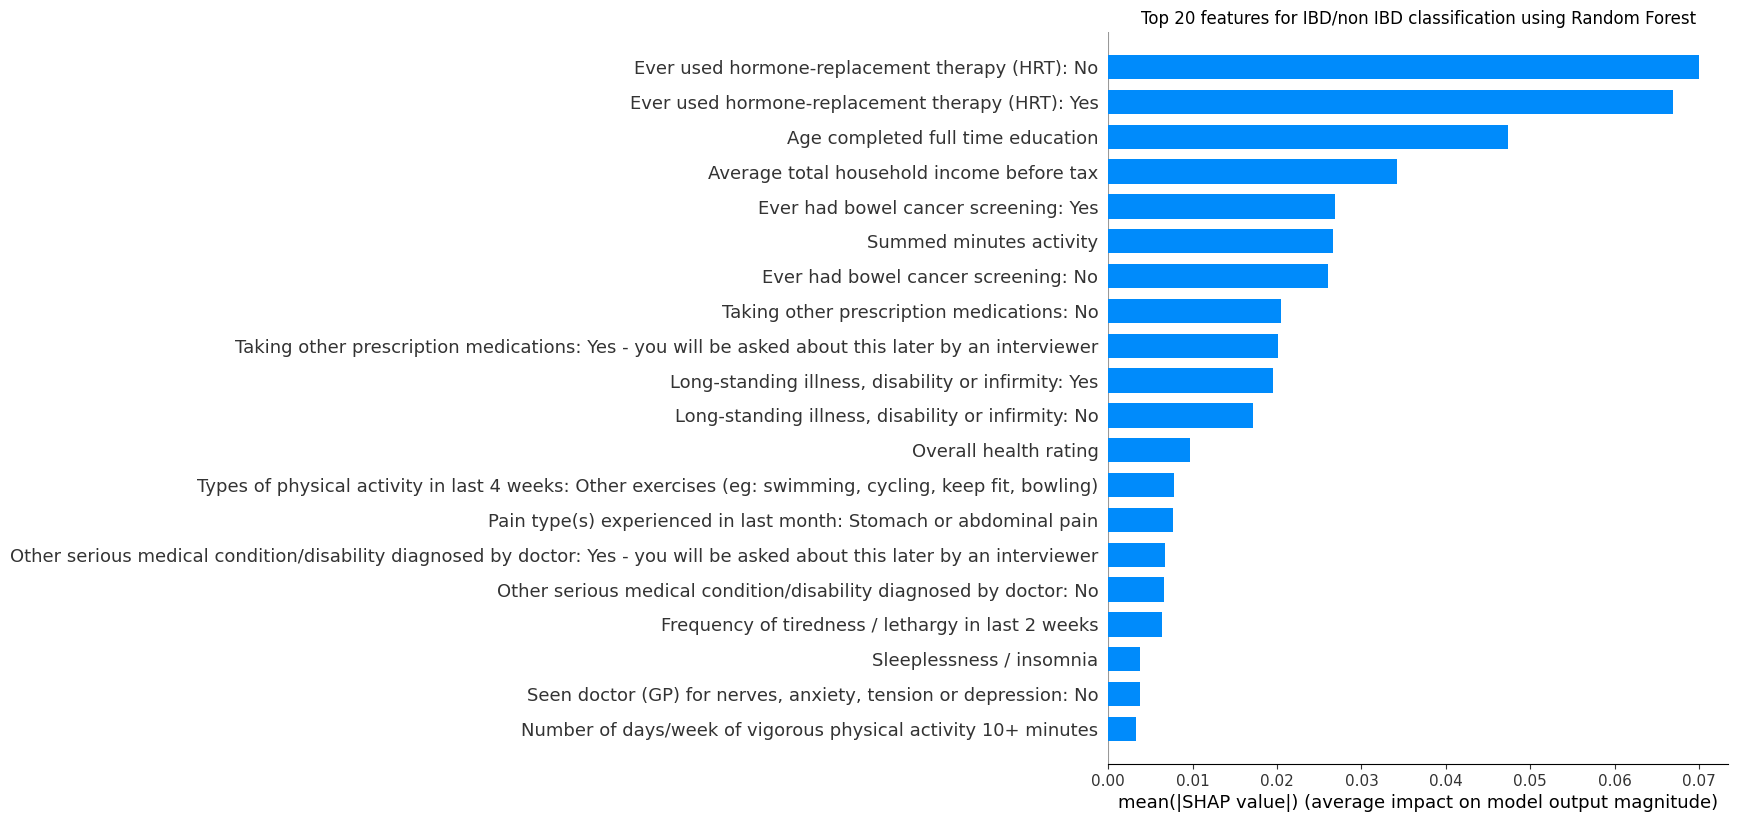

In [74]:
# Crear el plot SHAP (summary bar plot)
shap.summary_plot(shap_values[:,:,1], X_test, show=False, plot_type="bar", max_display=20)
# Agregar título con matplotlib
plt.title("Top 20 features for IBD/non IBD classification using Random Forest")
# Mostrar la figura con el título
plt.show()

/home/angie/.local/lib/python3.13/site-packages/shap/plots/_beeswarm.py:1150: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


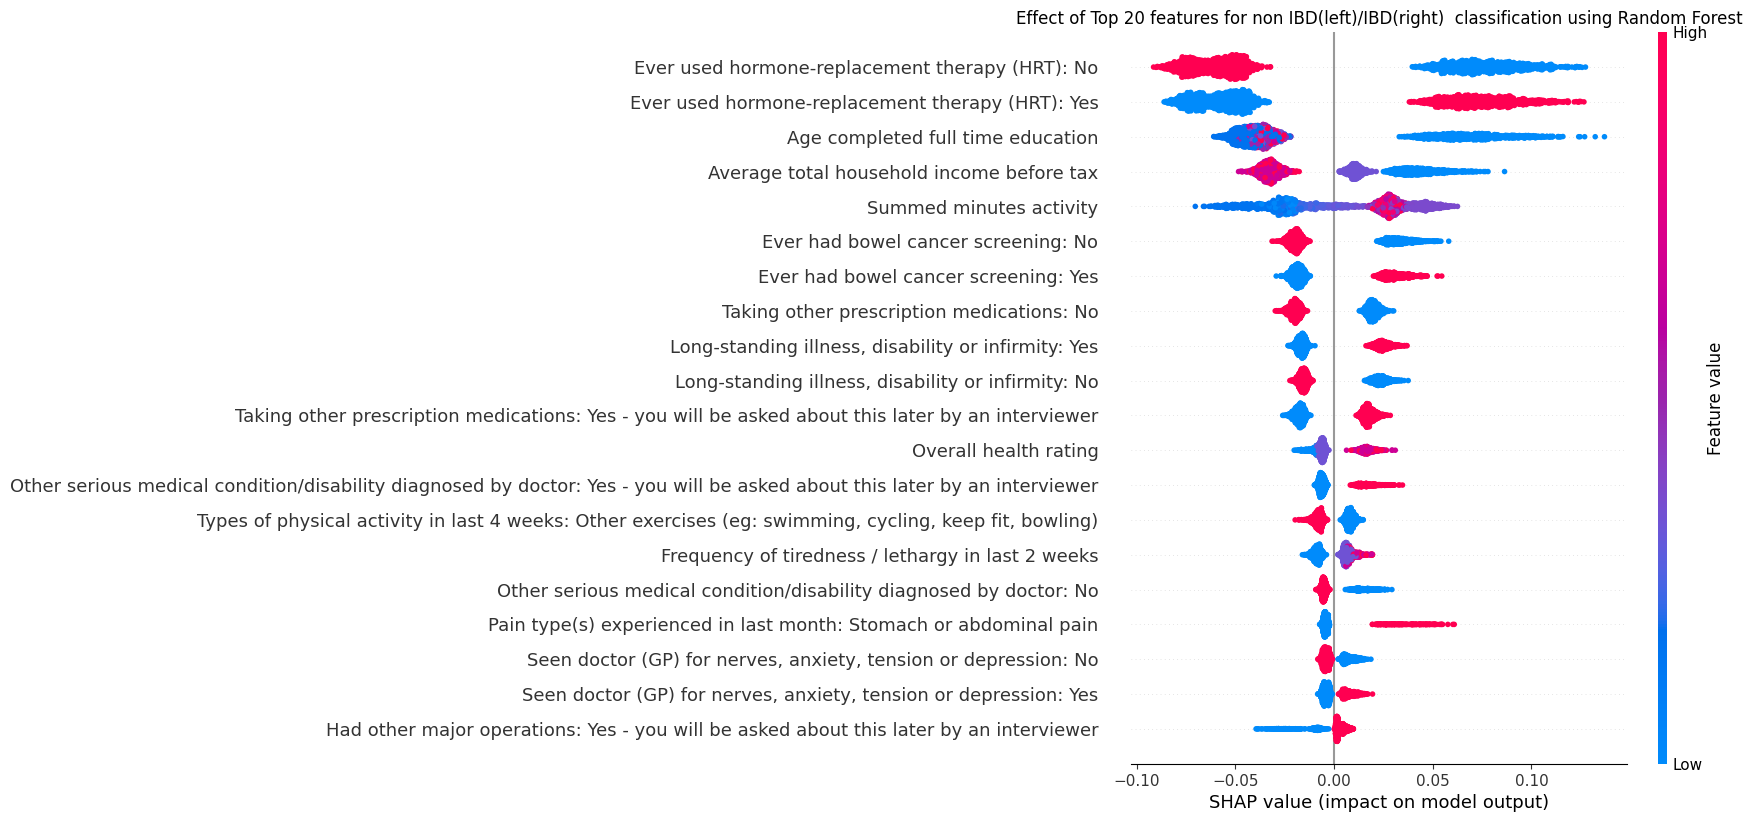

In [66]:
shap.summary_plot(shap_values[:,:,1], X_test, show=False) #ibd
plt.title("Effect of Top 20 features for non IBD(left)/IBD(right)  classification using Random Forest")
plt.show()

In [67]:
#importancia de las variables

importances = clf.feature_importances_
importances_df = pd.DataFrame({'variable': X.columns, 'importancia': importances})
importances_df = importances_df.sort_values(by='importancia', ascending=False)
top_varsRF = importances_df

top_varsRF

,variable,importancia
240,Ever used hormone-replacement therapy (HRT): No,0.072617
239,Ever used hormone-replacement therapy (HRT): Yes,0.070839
276,Age completed full time education,0.052249
314,Average total household income before tax,0.029595
313,Summed minutes activity,0.028199
...,...,...
198,Hearing difficulty/problems: I am completely deaf,0.000000
101,Pork intake: 5-6 times a week,0.000000
266,Ethnic background: Any other Black background,0.000000
259,Ethnic background: Asian or Asian British,0.000000
